# Imputation Methods

This notebook demonstrates various imputation methods for handling missing data:
- Mean/Median/Mode imputation
- Random imputation
- Nearest neighbor hot deck imputation
- Linear regression imputation
- Stochastic regression imputation
- K-nearest neighbors imputation

We will test these methods on three types of missing data patterns:
- **MCAR (Missing Completely At Random)**: Missing values are completely random
- **MAR (Missing At Random)**: Missing values depend on observed variables
- **MNAR (Missing Not At Random)**: Missing values depend on the unobserved values themselves

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Dataset Creation

First, let's create our complete dataset and then introduce different patterns of missing data.

In [101]:
# Set parameters for dataset generation
n_samples = 1000
np.random.seed(42)

# Generate correlated variables
age = np.random.normal(40, 12, n_samples)
income = 30000 + age * 1200 + np.random.normal(0, 15000, n_samples)
education_years = 8 + age * 0.15 + np.random.normal(0, 2, n_samples)
health_score = 80 - age * 0.5 + income * 0.0001 + np.random.normal(0, 10, n_samples)

# Create complete dataframe
df_complete = pd.DataFrame({
    'age': age,
    'income': income,
    'education_years': education_years,
    'health_score': health_score,
    'gender': np.random.choice(['Male', 'Female'], n_samples),
    'city': np.random.choice(['New York', 'Los Angeles', 'Chicago', 'Houston'], n_samples)
})

# Ensure positive values where appropriate
df_complete['age'] = np.clip(df_complete['age'], 18, 80)
df_complete['income'] = np.clip(df_complete['income'], 20000, 200000)
df_complete['education_years'] = np.clip(df_complete['education_years'], 8, 20)
df_complete['health_score'] = np.clip(df_complete['health_score'], 20, 100)

print("Complete Dataset Shape:", df_complete.shape)
print("\nDataset Info:")
print(df_complete.info())
print("\nFirst 5 rows:")
df_complete.head()

Complete Dataset Shape: (1000, 6)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1000 non-null   float64
 1   income           1000 non-null   float64
 2   education_years  1000 non-null   float64
 3   health_score     1000 non-null   float64
 4   gender           1000 non-null   object 
 5   city             1000 non-null   object 
dtypes: float64(4), object(2)
memory usage: 47.0+ KB
None

First 5 rows:


,age,income,education_years,health_score,gender,city
0,45.960570,106143.015352,13.543729,48.555941,Female,Chicago
1,38.340828,89878.499307,13.462087,61.213586,Male,Chicago
2,47.772262,88221.170497,13.581000,60.799930,Female,Los Angeles
3,58.276358,90227.578267,16.125531,78.761455,Female,Chicago
4,37.190160,85101.541108,9.791295,75.480606,Female,New York


In [102]:
# Display basic statistics
print("Dataset Statistics:")
df_complete.describe()

Dataset Statistics:


,age,income,education_years,health_score
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,40.331836,79342.086394,14.040772,67.627910
std,11.488206,20137.033781,2.633632,11.294040
min,18.000000,20000.000000,8.000000,37.319647
25%,32.228916,67394.886491,12.156386,59.795882
50%,40.303607,78694.954897,14.000688,67.948907
75%,47.775327,91931.488376,15.861207,75.553883
max,80.000000,159722.984613,20.000000,100.000000


## 2. Creating Missing Data Patterns

Now we'll create three datasets with different missing data mechanisms.

In [106]:
# MCAR: Missing Completely At Random
df_mcar = df_complete.copy()

# Randomly introduce missing values (10% missing rate)
missing_rate = 0.1
for col in ['income', 'health_score']:
    missing_indices = np.random.choice(df_mcar.index,
                                     size=int(len(df_mcar) * missing_rate),
                                     replace=False)
    df_mcar.loc[missing_indices, col] = np.nan

print("MCAR Dataset - Missing Values:")
print(df_mcar.isnull().sum())
print(f"\nMissing percentage: {df_mcar.isnull().sum().sum() / (df_mcar.shape[0] * df_mcar.shape[1]) * 100:.2f}%")

MCAR Dataset - Missing Values:
age                  0
income             100
education_years      0
health_score       100
gender               0
city                 0
dtype: int64

Missing percentage: 3.33%


In [111]:
# MAR: Missing At Random
df_mar = df_complete.copy()

# Income is more likely to be missing for younger people
young_threshold = df_mar['age'].quantile(0.3)
young_indices = df_mar[df_mar['age'] < young_threshold].index
missing_young = np.random.choice(young_indices,
                               size=int(len(young_indices) * 0.33),
                               replace=False)
df_mar.loc[missing_young, 'income'] = np.nan

# Health score is more likely to be missing for males
male_indices = df_mar[df_mar['gender'] == 'Male'].index
missing_male = np.random.choice(male_indices,
                              size=int(len(male_indices) * 0.2),
                              replace=False)
df_mar.loc[missing_male, 'health_score'] = np.nan

print("MAR Dataset - Missing Values:")
print(df_mar.isnull().sum())
print(f"\nMissing percentage: {df_mar.isnull().sum().sum() / (df_mar.shape[0] * df_mar.shape[1]) * 100:.2f}%")

MAR Dataset - Missing Values:
age                 0
income             99
education_years     0
health_score       99
gender              0
city                0
dtype: int64

Missing percentage: 3.30%


In [104]:
# MNAR: Missing Not At Random
df_mnar = df_complete.copy()

# High earners are more likely to not report their income
high_income_threshold = df_mnar['income'].quantile(0.8)
high_income_indices = df_mnar[df_mnar['income'] > high_income_threshold].index
missing_high_income = np.random.choice(high_income_indices,
                                     size=int(len(high_income_indices) * 0.5),
                                     replace=False)
df_mnar.loc[missing_high_income, 'income'] = np.nan

# People with low health scores are more likely to not report their health score
low_health_threshold = df_mnar['health_score'].quantile(0.2)
low_health_indices = df_mnar[df_mnar['health_score'] < low_health_threshold].index
missing_low_health = np.random.choice(low_health_indices,
                                    size=int(len(low_health_indices) * 0.5),
                                    replace=False)
df_mnar.loc[missing_low_health, 'health_score'] = np.nan

print("MNAR Dataset - Missing Values:")
print(df_mnar.isnull().sum())
print(f"\nMissing percentage: {df_mnar.isnull().sum().sum() / (df_mnar.shape[0] * df_mnar.shape[1]) * 100:.2f}%")

MNAR Dataset - Missing Values:
age                  0
income             100
education_years      0
health_score       100
gender               0
city                 0
dtype: int64

Missing percentage: 3.33%


## 3. Visualizing Missing Data Patterns

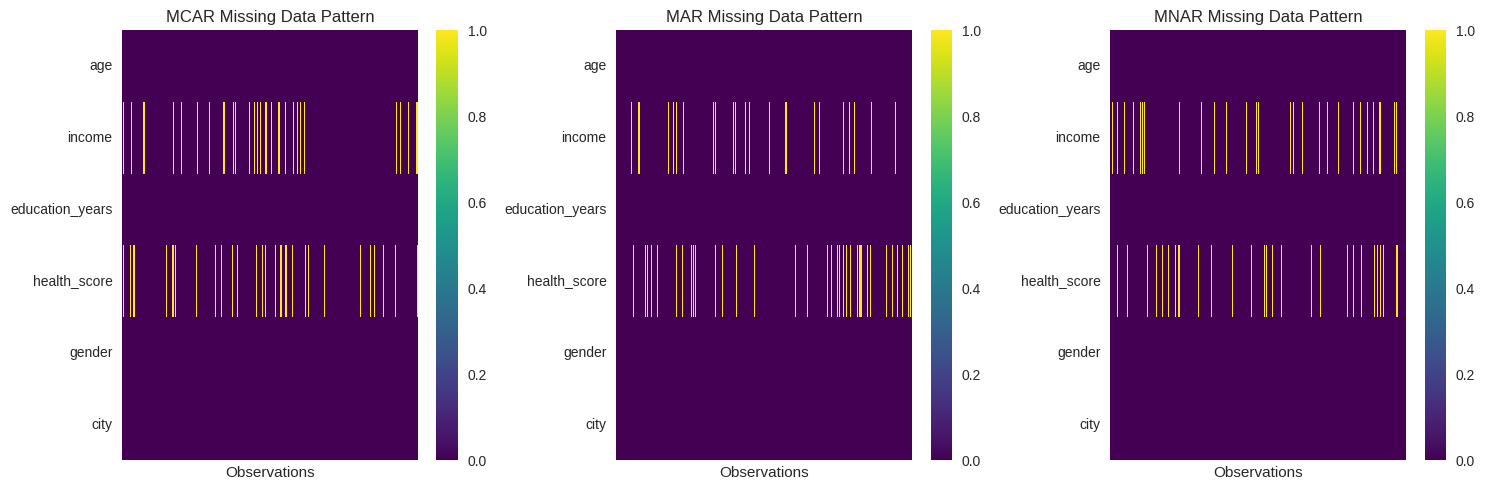

In [105]:
# Create visualization of missing data patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [df_mcar, df_mar, df_mnar]
titles = ['MCAR', 'MAR', 'MNAR']

for i, (df, title) in enumerate(zip(datasets, titles)):
    # Create missing data heatmap
    missing_data = df.isnull()
    sns.heatmap(missing_data.T, cbar=True, ax=axes[i], cmap='viridis',
                xticklabels=False, yticklabels=True)
    axes[i].set_title(f'{title} Missing Data Pattern')
    axes[i].set_xlabel('Observations')

plt.tight_layout()
plt.show()

## 4. Imputation Methods Implementation

Now we'll implement all the imputation methods covered in the theory class.

### 4.1 Mean/Median/Mode Imputation

This is the simplest imputation method where missing values are replaced with:
- **Mean**: For continuous variables with normal distribution
- **Median**: For continuous variables with skewed distribution
- **Mode**: For categorical variables

In [107]:
def mean_median_mode_imputation(df, strategy='mean'):
    """
    Perform mean/median/mode imputation on a dataframe.

    Parameters:
    df: DataFrame with missing values
    strategy: 'mean', 'median', or 'mode'

    Returns:
    DataFrame with imputed values
    """
    df_imputed = df.copy()

    # For numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    for col in numerical_cols:
        if df_imputed[col].isnull().any():
            if strategy == 'mean':
                fill_value = df_imputed[col].mean()
            elif strategy == 'median':
                fill_value = df_imputed[col].median()
            elif strategy == 'mode':
                fill_value = df_imputed[col].mode().iloc[0] if not df_imputed[col].mode().empty else df_imputed[col].mean()

            df_imputed[col].fillna(fill_value, inplace=True)
            print(f"Imputed {col} with {strategy}: {fill_value:.2f}")

    # For categorical columns (always use mode)
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        if df_imputed[col].isnull().any():
            mode_value = df_imputed[col].mode().iloc[0] if not df_imputed[col].mode().empty else 'Unknown'
            df_imputed[col].fillna(mode_value, inplace=True)
            print(f"Imputed {col} with mode: {mode_value}")

    return df_imputed

In [112]:
# Apply mean imputation to all three datasets
print("=== Mean Imputation ===")
df_mcar_mean = mean_median_mode_imputation(df_mcar, strategy='mean')
print("\nMCAR dataset after mean imputation:")
print(df_mcar_mean.isnull().sum())

print("\n" + "="*50)
df_mar_mean = mean_median_mode_imputation(df_mar, strategy='mean')
print("\nMAR dataset after mean imputation:")
print(df_mar_mean.isnull().sum())

print("\n" + "="*50)
df_mnar_mean = mean_median_mode_imputation(df_mnar, strategy='mean')
print("\nMNAR dataset after mean imputation:")
print(df_mnar_mean.isnull().sum())

=== Mean Imputation ===
Imputed income with mean: 79349.70
Imputed health_score with mean: 67.52

MCAR dataset after mean imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Imputed income with mean: 81069.88
Imputed health_score with mean: 67.75

MAR dataset after mean imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Imputed income with mean: 76243.85
Imputed health_score with mean: 69.49

MNAR dataset after mean imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


In [109]:
# Apply median imputation to all three datasets
print("=== Median Imputation ===")
df_mcar_median = mean_median_mode_imputation(df_mcar, strategy='median')
print("\nMCAR dataset after median imputation:")
print(df_mcar_median.isnull().sum())

print("\n" + "="*50)
df_mar_median = mean_median_mode_imputation(df_mar, strategy='median')
print("\nMAR dataset after median imputation:")
print(df_mar_median.isnull().sum())

print("\n" + "="*50)
df_mnar_median = mean_median_mode_imputation(df_mnar, strategy='median')
print("\nMNAR dataset after median imputation:")
print(df_mnar_median.isnull().sum())

=== Median Imputation ===
Imputed income with median: 78533.20
Imputed health_score with median: 67.91

MCAR dataset after median imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Imputed income with median: 50506.55
Imputed health_score with median: 62.00

MAR dataset after median imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Imputed income with median: 76047.41
Imputed health_score with median: 69.19

MNAR dataset after median imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


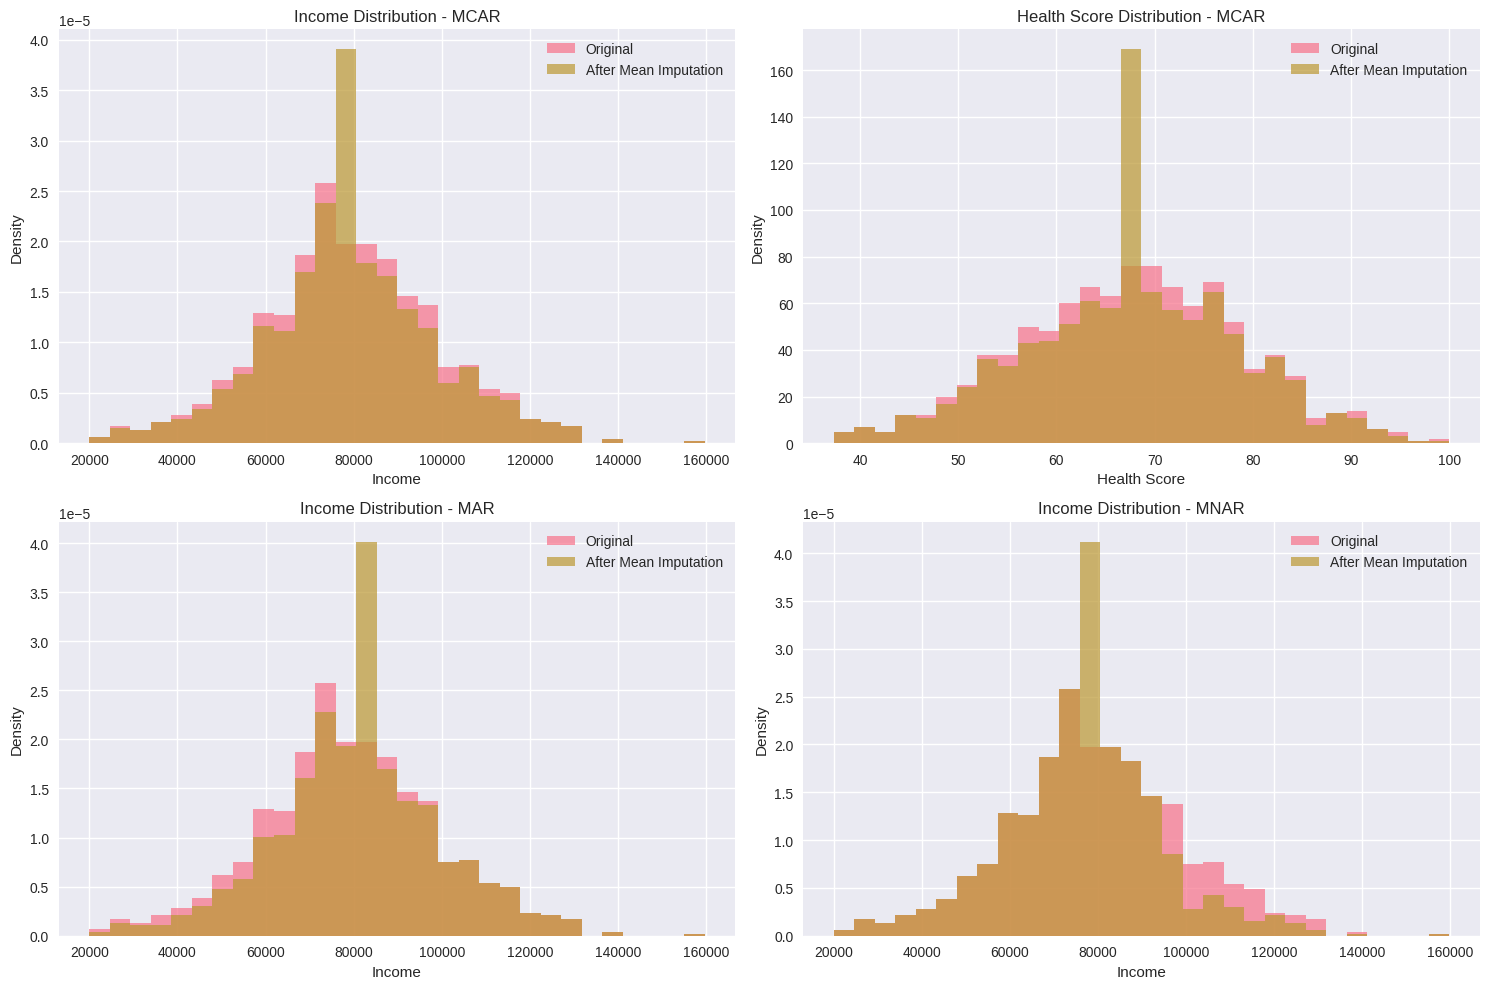

In [115]:
# Compare distributions before and after mean imputation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Income distribution
axes[0,0].hist(df_complete['income'], bins=30, alpha=0.7, label='Original', density=True)
axes[0,0].hist(df_mcar_mean['income'], bins=30, alpha=0.7, label='After Mean Imputation', density=True)
axes[0,0].set_title('Income Distribution - MCAR')
axes[0,0].legend()
axes[0,0].set_xlabel('Income')
axes[0,0].set_ylabel('Density')

# Health score distribution
axes[0,1].hist(df_complete['health_score'], bins=30, alpha=0.7, label='Original', density=True)
axes[0,1].hist(df_mcar_mean['health_score'], bins=30, alpha=0.7, label='After Mean Imputation', density=True)
axes[0,1].set_title('Health Score Distribution - MCAR')
axes[0,1].legend()
axes[0,1].set_xlabel('Health Score')
axes[0,1].set_ylabel('Density')

# Income distribution for MAR
axes[1,0].hist(df_complete['income'], bins=30, alpha=0.7, label='Original', density=True)
axes[1,0].hist(df_mar_mean['income'], bins=30, alpha=0.7, label='After Mean Imputation', density=True)
axes[1,0].set_title('Income Distribution - MAR')
axes[1,0].legend()
axes[1,0].set_xlabel('Income')
axes[1,0].set_ylabel('Density')

# Income distribution for MNAR
axes[1,1].hist(df_complete['income'], bins=30, alpha=0.7, label='Original', density=True)
axes[1,1].hist(df_mnar_mean['income'], bins=30, alpha=0.7, label='After Mean Imputation', density=True)
axes[1,1].set_title('Income Distribution - MNAR')
axes[1,1].legend()
axes[1,1].set_xlabel('Income')
axes[1,1].set_ylabel('Density')

plt.tight_layout()
plt.show()

**Observations:**
- Mean/median/mode imputation is simple and fast
- It reduces variance in the data (notice the spike at the mean value)
- Works reasonably well for MCAR data
- May introduce bias for MAR and MNAR data
- Does not preserve relationships between variables

### 4.2 Random Imputation

Random imputation replaces missing values with randomly selected values from the observed data. This method preserves the original distribution of the variable but ignores relationships between variables.

In [116]:
def random_imputation(df, random_state=42):
    """
    Perform random imputation on a dataframe.
    Missing values are replaced with randomly selected observed values.

    Parameters:
    df: DataFrame with missing values
    random_state: Random seed for reproducibility

    Returns:
    DataFrame with imputed values
    """
    df_imputed = df.copy()
    np.random.seed(random_state)

    for col in df_imputed.columns:
        if df_imputed[col].isnull().any():
            # Get non-missing values
            observed_values = df_imputed[col].dropna().values

            # Get indices of missing values
            missing_indices = df_imputed[col].isnull()
            n_missing = missing_indices.sum()

            # Randomly sample from observed values
            random_values = np.random.choice(observed_values, size=n_missing, replace=True)

            # Fill missing values
            df_imputed.loc[missing_indices, col] = random_values

            print(f"Imputed {n_missing} missing values in {col} with random sampling")

    return df_imputed

In [117]:
# Apply random imputation to all three datasets
print("=== Random Imputation ===")
df_mcar_random = random_imputation(df_mcar, random_state=42)
print("\nMCAR dataset after random imputation:")
print(df_mcar_random.isnull().sum())

print("\n" + "="*50)
df_mar_random = random_imputation(df_mar, random_state=42)
print("\nMAR dataset after random imputation:")
print(df_mar_random.isnull().sum())

print("\n" + "="*50)
df_mnar_random = random_imputation(df_mnar, random_state=42)
print("\nMNAR dataset after random imputation:")
print(df_mnar_random.isnull().sum())

=== Random Imputation ===
Imputed 100 missing values in income with random sampling
Imputed 100 missing values in health_score with random sampling

MCAR dataset after random imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Imputed 99 missing values in income with random sampling
Imputed 99 missing values in health_score with random sampling

MAR dataset after random imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Imputed 100 missing values in income with random sampling
Imputed 100 missing values in health_score with random sampling

MNAR dataset after random imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


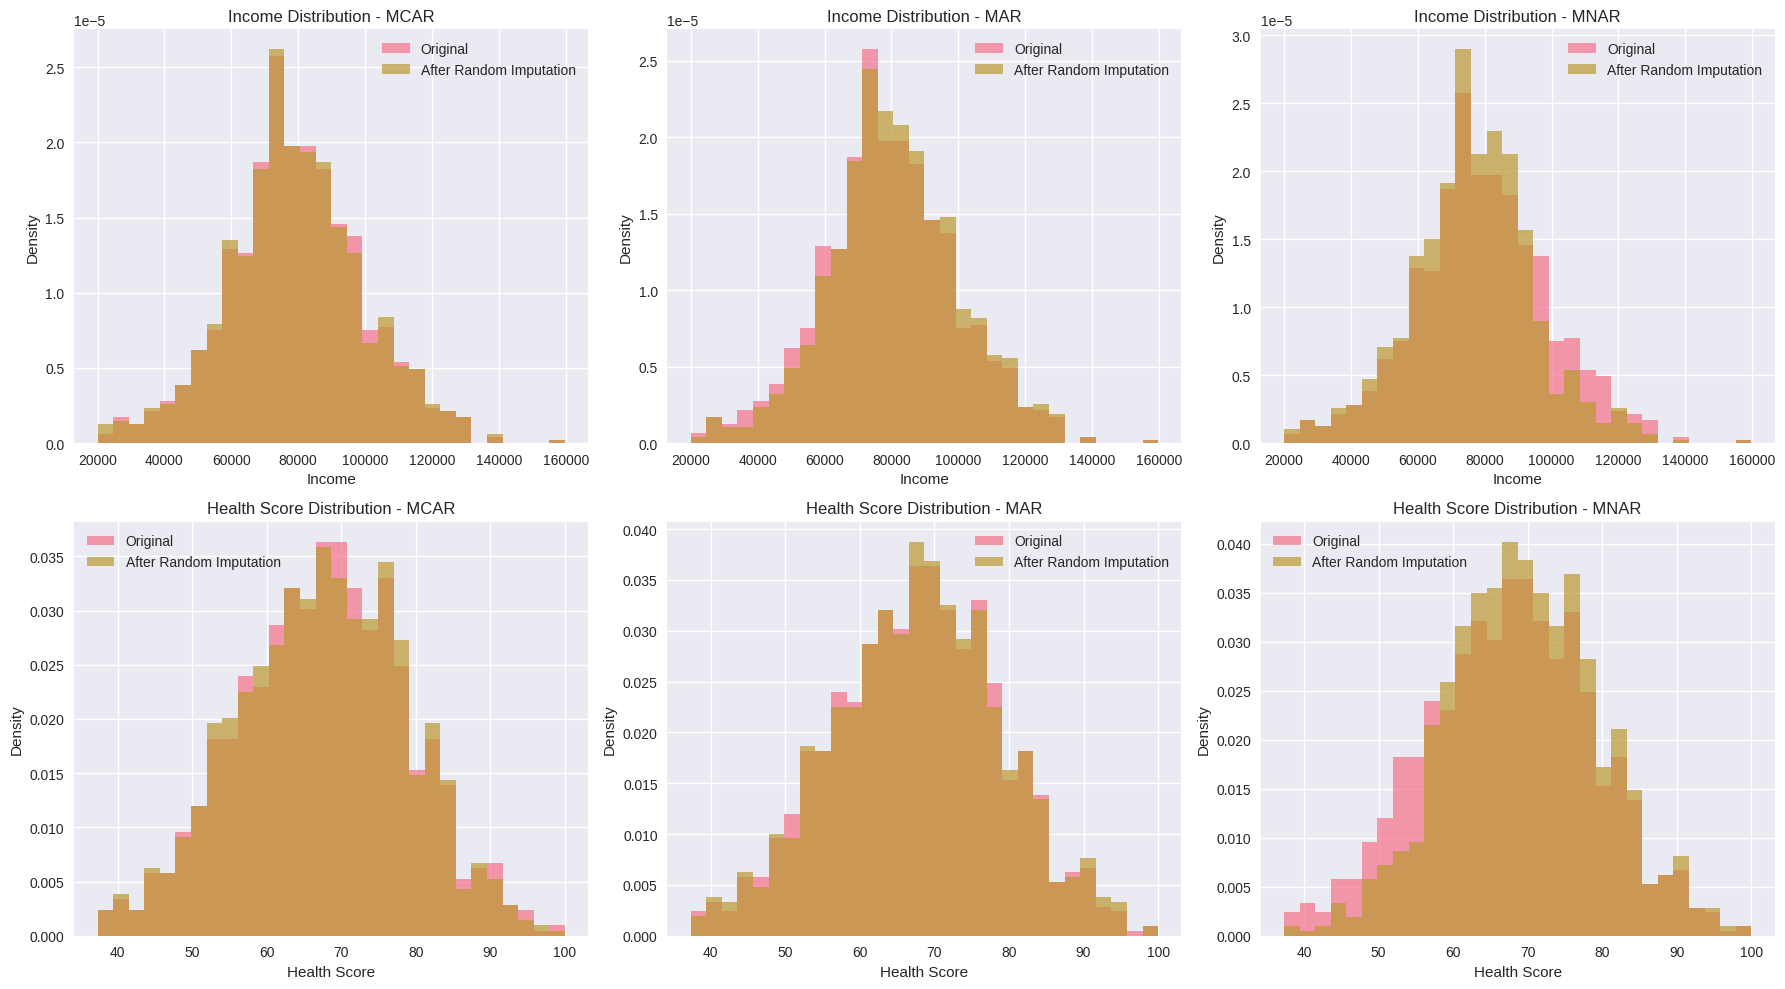

In [118]:
# Compare distributions: Original vs Random Imputation
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

datasets = [df_mcar_random, df_mar_random, df_mnar_random]
titles = ['MCAR', 'MAR', 'MNAR']

# Income distributions
for i, (df_imputed, title) in enumerate(zip(datasets, titles)):
    axes[0,i].hist(df_complete['income'], bins=30, alpha=0.7, label='Original', density=True)
    axes[0,i].hist(df_imputed['income'], bins=30, alpha=0.7, label='After Random Imputation', density=True)
    axes[0,i].set_title(f'Income Distribution - {title}')
    axes[0,i].legend()
    axes[0,i].set_xlabel('Income')
    axes[0,i].set_ylabel('Density')

# Health score distributions
for i, (df_imputed, title) in enumerate(zip(datasets, titles)):
    axes[1,i].hist(df_complete['health_score'], bins=30, alpha=0.7, label='Original', density=True)
    axes[1,i].hist(df_imputed['health_score'], bins=30, alpha=0.7, label='After Random Imputation', density=True)
    axes[1,i].set_title(f'Health Score Distribution - {title}')
    axes[1,i].legend()
    axes[1,i].set_xlabel('Health Score')
    axes[1,i].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [119]:
# Compare variance preservation
print("Variance Comparison - Random Imputation")
print("="*50)

variables = ['income', 'health_score']
datasets_random = [df_mcar_random, df_mar_random, df_mnar_random]
dataset_names = ['MCAR', 'MAR', 'MNAR']

for var in variables:
    print(f"\n{var.upper()} VARIANCE:")
    print(f"Original: {df_complete[var].var():.2f}")

    for df_imp, name in zip(datasets_random, dataset_names):
        print(f"{name} Random Imputation: {df_imp[var].var():.2f}")

Variance Comparison - Random Imputation

INCOME VARIANCE:
Original: 405500129.48
MCAR Random Imputation: 418168166.25
MAR Random Imputation: 388128049.48
MNAR Random Imputation: 346066416.29

HEALTH_SCORE VARIANCE:
Original: 127.56
MCAR Random Imputation: 127.64
MAR Random Imputation: 128.94
MNAR Random Imputation: 103.67


**Observations:**
- Random imputation preserves the marginal distribution of variables better than mean imputation
- It maintains the variance of the original data
- However, it still ignores relationships between variables
- The method is simple to implement and computationally efficient
- Works well when the missing data mechanism is MCAR

### 4.3 Nearest Neighbor Hot Deck Imputation

Hot deck imputation replaces missing values with observed values from "similar" records (donors). The nearest neighbor approach finds the most similar complete record based on other variables and uses its value to impute the missing value.

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

def hot_deck_imputation(df, distance_cols=None, random_state=42):
    """
    Perform hot deck imputation using nearest neighbor approach.

    Parameters:
    df: DataFrame with missing values
    distance_cols: List of columns to use for distance calculation (if None, use all numeric columns)
    random_state: Random seed for reproducibility

    Returns:
    DataFrame with imputed values
    """
    df_imputed = df.copy()
    np.random.seed(random_state)

    # Encode categorical variables for distance calculation
    df_encoded = df_imputed.copy()
    label_encoders = {}

    for col in df_encoded.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

    # Select columns for distance calculation
    if distance_cols is None:
        distance_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

    # Standardize the features for distance calculation
    scaler = StandardScaler()

    # Process each column with missing values
    for target_col in df_imputed.columns:
        if df_imputed[target_col].isnull().any():
            print(f"\nImputing {target_col}...")

            # Get available columns for distance calculation (excluding target column)
            available_cols = [col for col in distance_cols if col != target_col and not df_encoded[col].isnull().all()]

            if not available_cols:
                print(f"No suitable columns for distance calculation for {target_col}")
                continue

            # Get complete cases (no missing values in distance columns and target column)
            complete_mask = df_encoded[available_cols + [target_col]].notna().all(axis=1)
            complete_data = df_encoded[complete_mask]

            if len(complete_data) == 0:
                print(f"No complete cases available for {target_col}")
                continue

            # Standardize the distance columns
            X_complete = scaler.fit_transform(complete_data[available_cols])

            # Find missing cases
            missing_mask = df_encoded[target_col].isnull() & df_encoded[available_cols].notna().all(axis=1)
            missing_data = df_encoded[missing_mask]

            if len(missing_data) == 0:
                continue

            # Standardize missing cases using the same scaler
            X_missing = scaler.transform(missing_data[available_cols])

            # Find nearest neighbors
            distances = euclidean_distances(X_missing, X_complete)
            nearest_indices = np.argmin(distances, axis=1)

            # Impute values
            imputed_values = complete_data.iloc[nearest_indices][target_col].values
            df_imputed.loc[missing_mask, target_col] = imputed_values

            print(f"Imputed {len(imputed_values)} values for {target_col}")

    return df_imputed

In [121]:
# Apply hot deck imputation to all three datasets
print("=== Hot Deck Imputation ===")

# For hot deck, we'll use age, education_years, gender, and city to find nearest neighbors
distance_cols = ['age', 'education_years', 'gender', 'city']

df_mcar_hotdeck = hot_deck_imputation(df_mcar, distance_cols=distance_cols, random_state=42)
print("\nMCAR dataset after hot deck imputation:")
print(df_mcar_hotdeck.isnull().sum())

print("\n" + "="*50)
df_mar_hotdeck = hot_deck_imputation(df_mar, distance_cols=distance_cols, random_state=42)
print("\nMAR dataset after hot deck imputation:")
print(df_mar_hotdeck.isnull().sum())

print("\n" + "="*50)
df_mnar_hotdeck = hot_deck_imputation(df_mnar, distance_cols=distance_cols, random_state=42)
print("\nMNAR dataset after hot deck imputation:")
print(df_mnar_hotdeck.isnull().sum())

=== Hot Deck Imputation ===

Imputing income...
Imputed 100 values for income

Imputing health_score...
Imputed 100 values for health_score

MCAR dataset after hot deck imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


Imputing income...
Imputed 99 values for income

Imputing health_score...
Imputed 99 values for health_score

MAR dataset after hot deck imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


Imputing income...
Imputed 100 values for income

Imputing health_score...
Imputed 100 values for health_score

MNAR dataset after hot deck imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


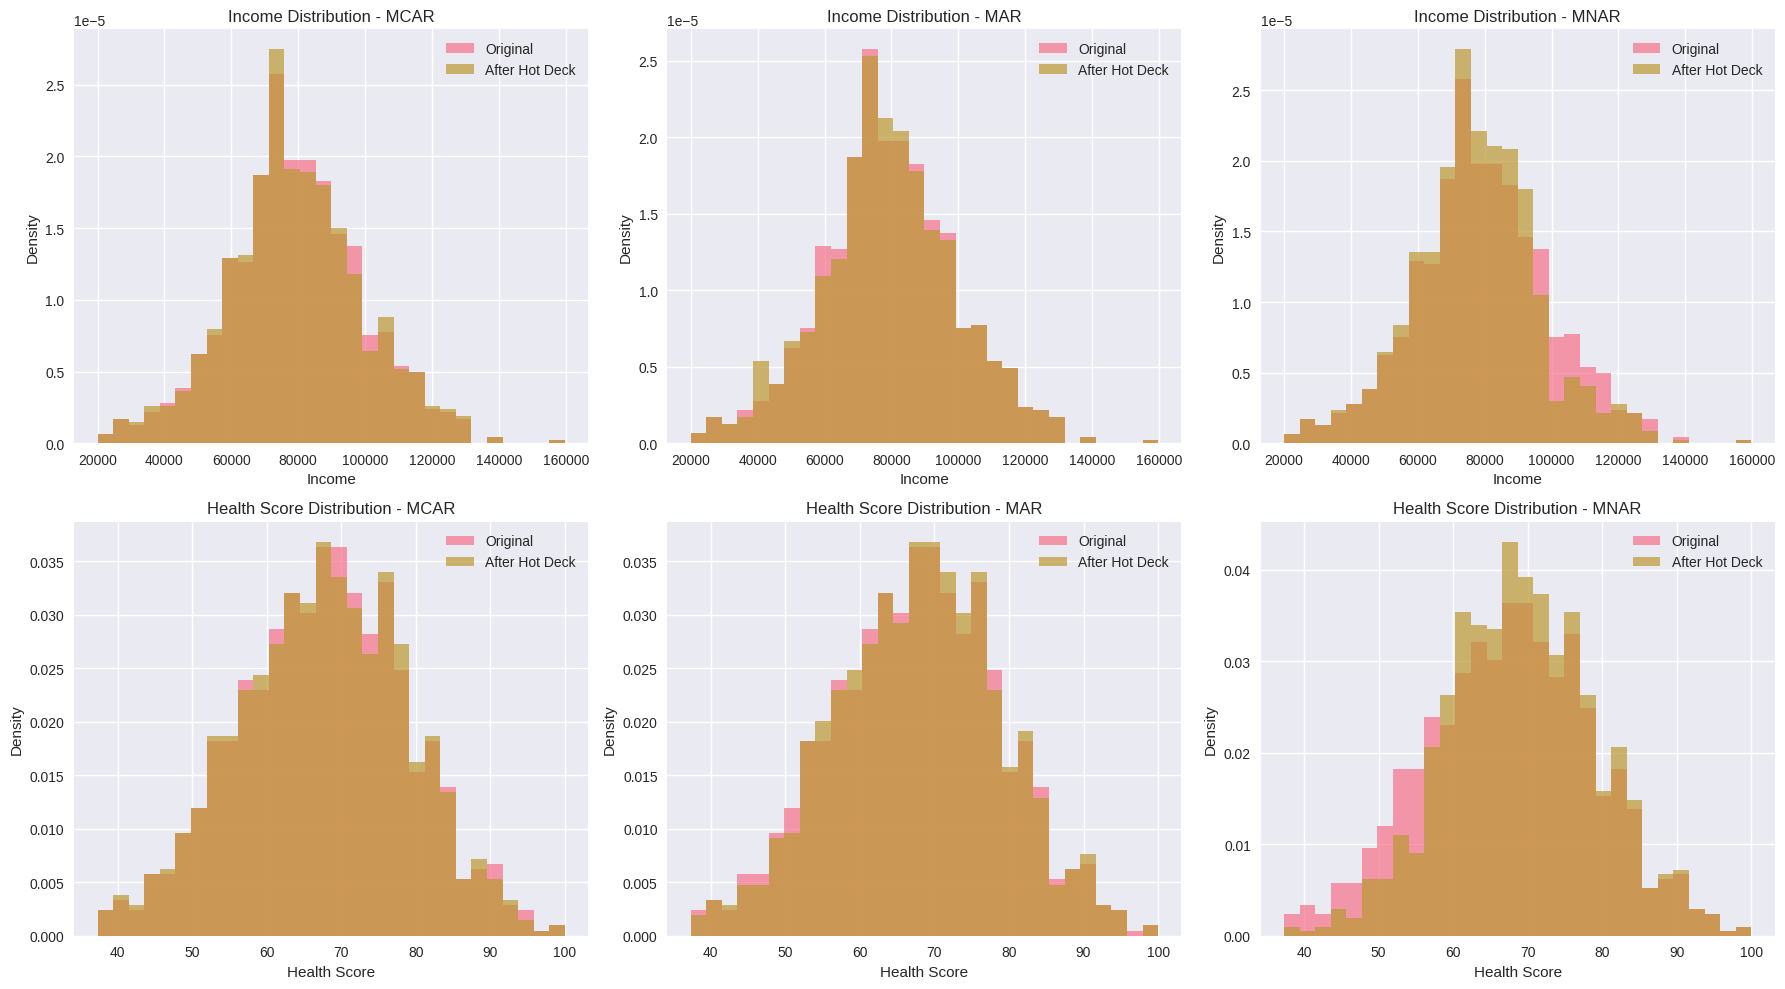

In [122]:
# Visualize the results of hot deck imputation
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

datasets_hotdeck = [df_mcar_hotdeck, df_mar_hotdeck, df_mnar_hotdeck]
titles = ['MCAR', 'MAR', 'MNAR']

# Income distributions
for i, (df_imputed, title) in enumerate(zip(datasets_hotdeck, titles)):
    axes[0,i].hist(df_complete['income'], bins=30, alpha=0.7, label='Original', density=True)
    axes[0,i].hist(df_imputed['income'], bins=30, alpha=0.7, label='After Hot Deck', density=True)
    axes[0,i].set_title(f'Income Distribution - {title}')
    axes[0,i].legend()
    axes[0,i].set_xlabel('Income')
    axes[0,i].set_ylabel('Density')

# Health score distributions
for i, (df_imputed, title) in enumerate(zip(datasets_hotdeck, titles)):
    axes[1,i].hist(df_complete['health_score'], bins=30, alpha=0.7, label='Original', density=True)
    axes[1,i].hist(df_imputed['health_score'], bins=30, alpha=0.7, label='After Hot Deck', density=True)
    axes[1,i].set_title(f'Health Score Distribution - {title}')
    axes[1,i].legend()
    axes[1,i].set_xlabel('Health Score')
    axes[1,i].set_ylabel('Density')

plt.tight_layout()
plt.show()

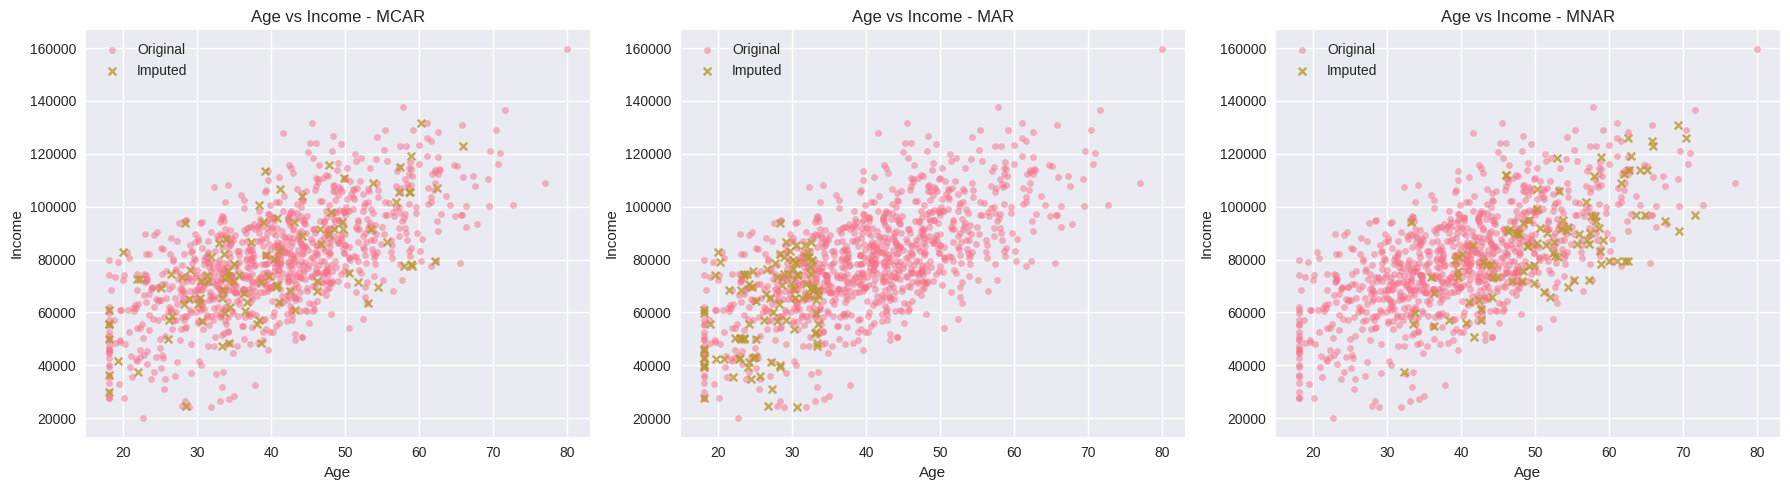

In [123]:
# Analyze the relationship preservation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plots: Age vs Income
for i, (df_imputed, title) in enumerate(zip(datasets_hotdeck, titles)):
    axes[i].scatter(df_complete['age'], df_complete['income'], alpha=0.5, label='Original', s=20)

    # Highlight imputed values
    if title == 'MCAR':
        missing_mask = df_mcar['income'].isnull()
    elif title == 'MAR':
        missing_mask = df_mar['income'].isnull()
    else:
        missing_mask = df_mnar['income'].isnull()

    if missing_mask.any():
        axes[i].scatter(df_imputed.loc[missing_mask, 'age'],
                       df_imputed.loc[missing_mask, 'income'],
                       alpha=0.8, label='Imputed', s=30, marker='x')

    axes[i].set_title(f'Age vs Income - {title}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Income')
    axes[i].legend()

plt.tight_layout()
plt.show()

**Observations:**
- Hot deck imputation preserves relationships between variables better than simple imputation methods
- It uses information from similar records to make more realistic imputations
- The method maintains the distribution of the target variable
- Performance depends on the quality of the similarity measure and available donor records
- Works well when there are strong relationships between variables

### 4.4 Linear Regression Imputation

Linear regression imputation uses linear regression models to predict missing values based on other variables. This method explicitly models the relationships between variables and can provide more accurate imputations when linear relationships exist.

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

def regression_imputation(df, random_state=42):
    """
    Perform linear regression imputation on a dataframe.

    Parameters:
    df: DataFrame with missing values
    random_state: Random seed for reproducibility

    Returns:
    DataFrame with imputed values
    """
    df_imputed = df.copy()
    np.random.seed(random_state)

    # Encode categorical variables
    df_encoded = df_imputed.copy()
    label_encoders = {}

    for col in df_encoded.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

    # Process each column with missing values
    for target_col in df_encoded.columns:
        if df_encoded[target_col].isnull().any():
            print(f"\nImputing {target_col} using linear regression...")

            # Select predictor columns (all other columns)
            if target_col=='income':
              predictor_cols = ['age','education_years','gender']
            elif target_col=='health_score':
              predictor_cols=['age','gender']

            # Get complete cases for training
            complete_mask = df_encoded[predictor_cols + [target_col]].notna().all(axis=1)

            if complete_mask.sum() < 2:
                print(f"Not enough complete cases for {target_col}. Using mean imputation.")
                df_imputed[target_col].fillna(df_imputed[target_col].mean(), inplace=True)
                continue

            # Prepare training data
            X_train = df_encoded.loc[complete_mask, predictor_cols]
            y_train = df_encoded.loc[complete_mask, target_col]

            # Train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Find missing cases that have complete predictor data
            missing_mask = (df_encoded[target_col].isnull() &
                          df_encoded[predictor_cols].notna().all(axis=1))

            if missing_mask.sum() == 0:
                print(f"No cases with complete predictor data for {target_col}")
                continue

            # Predict missing values
            X_missing = df_encoded.loc[missing_mask, predictor_cols]
            predicted_values = model.predict(X_missing)



            df_imputed.loc[missing_mask, target_col] = predicted_values

            # Print model performance
            r2_score = model.score(X_train, y_train)
            print(f"Model R² score: {r2_score:.3f}")
            print(f"Imputed {missing_mask.sum()} values for {target_col}")

    return df_imputed

In [125]:
# Apply regression imputation to all three datasets
print("=== Linear Regression Imputation ===")

df_mcar_regression = regression_imputation(df_mcar, random_state=42)
print("\nMCAR dataset after regression imputation:")
print(df_mcar_regression.isnull().sum())

print("\n" + "="*70)
df_mar_regression = regression_imputation(df_mar, random_state=42)
print("\nMAR dataset after regression imputation:")
print(df_mar_regression.isnull().sum())

print("\n" + "="*70)
df_mnar_regression = regression_imputation(df_mnar, random_state=42)
print("\nMNAR dataset after regression imputation:")
print(df_mnar_regression.isnull().sum())

=== Linear Regression Imputation ===

Imputing income using linear regression...
Model R² score: 0.463
Imputed 100 values for income

Imputing health_score using linear regression...
Model R² score: 0.170
Imputed 100 values for health_score

MCAR dataset after regression imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


Imputing income using linear regression...
Model R² score: 0.430
Imputed 99 values for income

Imputing health_score using linear regression...
Model R² score: 0.185
Imputed 99 values for health_score

MAR dataset after regression imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


Imputing income using linear regression...
Model R² score: 0.408
Imputed 100 values for income

Imputing health_score using linear regression...
Model R² score: 0.127
Imputed 100 values for h

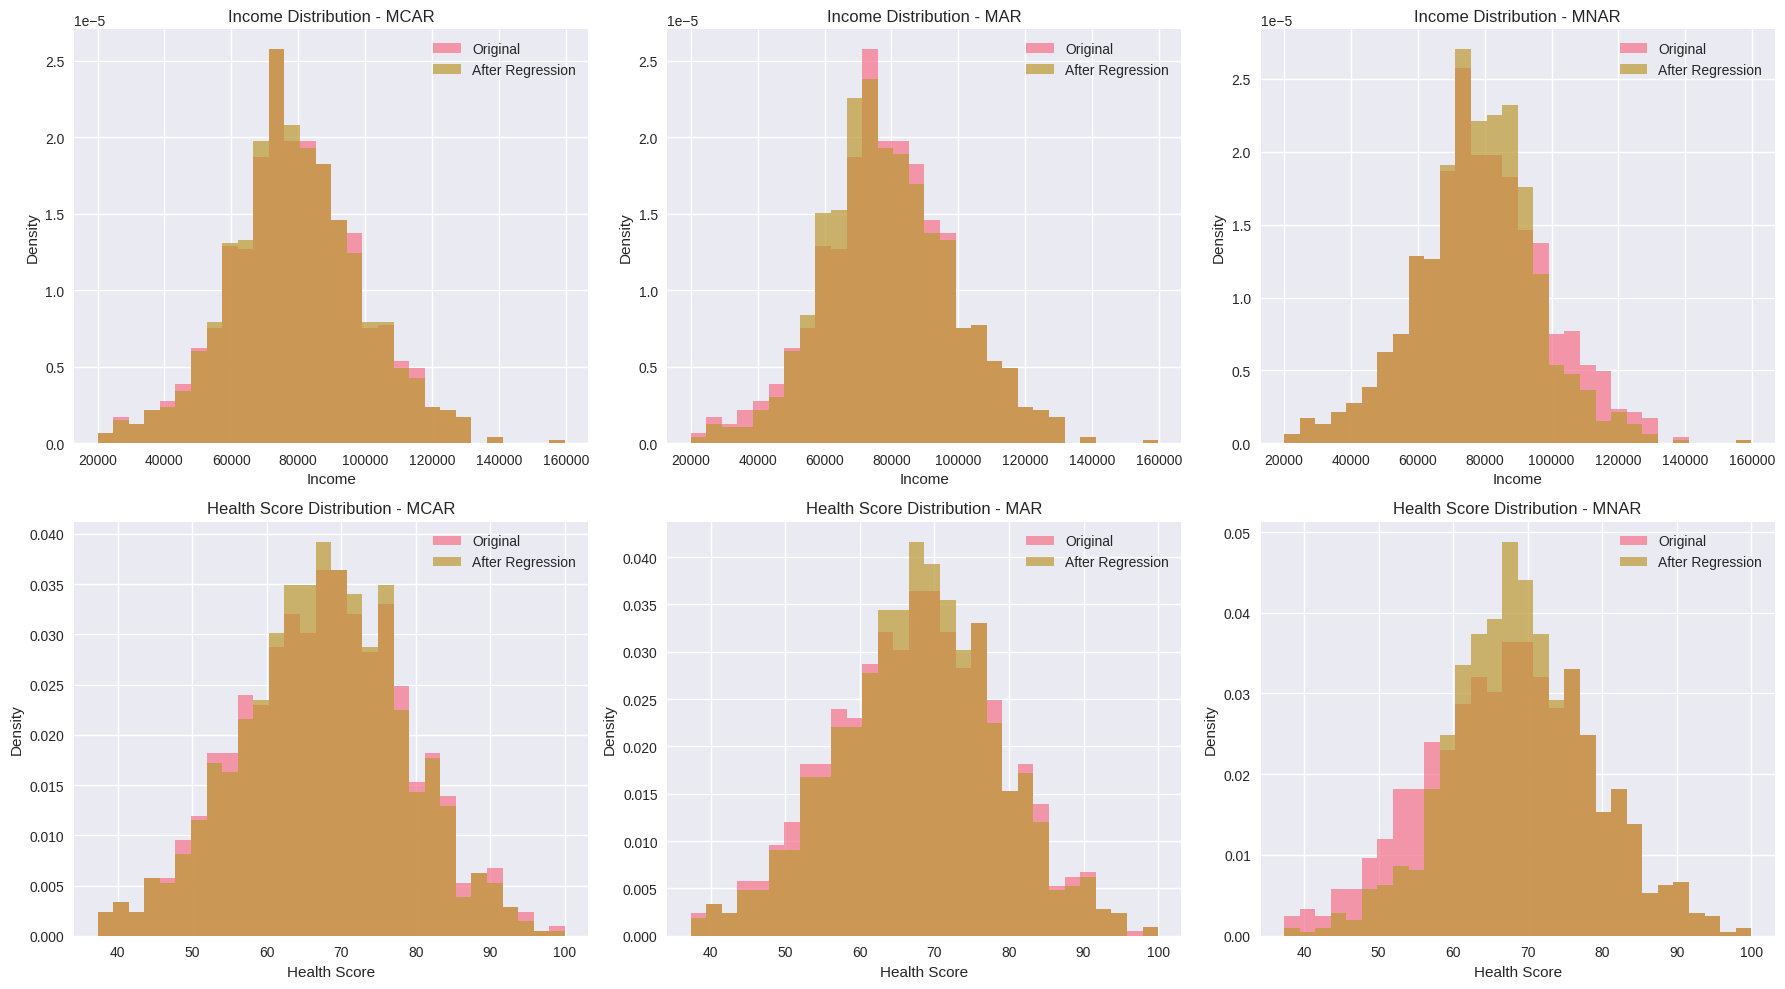

In [126]:
# Visualize regression imputation results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

datasets_regression = [df_mcar_regression, df_mar_regression, df_mnar_regression]
titles = ['MCAR', 'MAR', 'MNAR']

# Income distributions
for i, (df_imputed, title) in enumerate(zip(datasets_regression, titles)):
    axes[0,i].hist(df_complete['income'], bins=30, alpha=0.7, label='Original', density=True)
    axes[0,i].hist(df_imputed['income'], bins=30, alpha=0.7, label='After Regression', density=True)
    axes[0,i].set_title(f'Income Distribution - {title}')
    axes[0,i].legend()
    axes[0,i].set_xlabel('Income')
    axes[0,i].set_ylabel('Density')

# Health score distributions
for i, (df_imputed, title) in enumerate(zip(datasets_regression, titles)):
    axes[1,i].hist(df_complete['health_score'], bins=30, alpha=0.7, label='Original', density=True)
    axes[1,i].hist(df_imputed['health_score'], bins=30, alpha=0.7, label='After Regression', density=True)
    axes[1,i].set_title(f'Health Score Distribution - {title}')
    axes[1,i].legend()
    axes[1,i].set_xlabel('Health Score')
    axes[1,i].set_ylabel('Density')

plt.tight_layout()
plt.show()

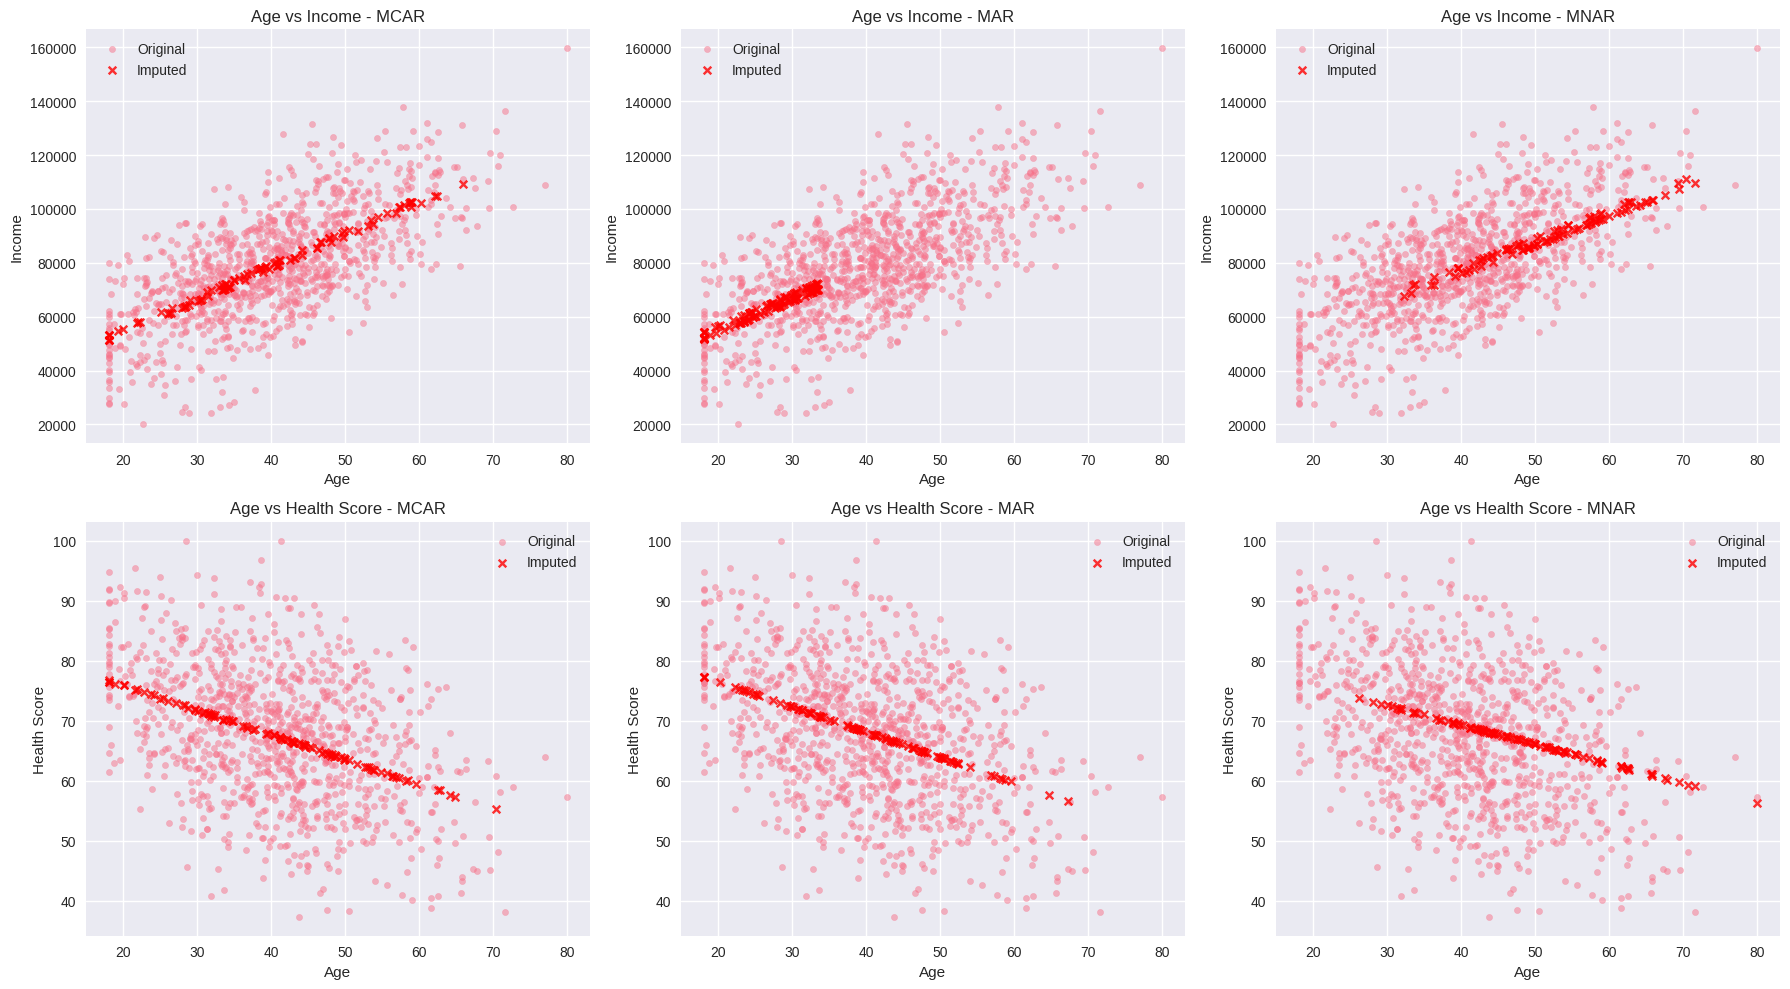

In [127]:
# Analyze relationship preservation with regression imputation
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age vs Income relationships
for i, (df_imputed, title) in enumerate(zip(datasets_regression, titles)):
    axes[0,i].scatter(df_complete['age'], df_complete['income'], alpha=0.5, label='Original', s=20)

    # Highlight imputed values
    if title == 'MCAR':
        missing_mask = df_mcar['income'].isnull()
    elif title == 'MAR':
        missing_mask = df_mar['income'].isnull()
    else:
        missing_mask = df_mnar['income'].isnull()

    if missing_mask.any():
        axes[0,i].scatter(df_imputed.loc[missing_mask, 'age'],
                         df_imputed.loc[missing_mask, 'income'],
                         alpha=0.8, label='Imputed', s=30, marker='x', color='red')

    axes[0,i].set_title(f'Age vs Income - {title}')
    axes[0,i].set_xlabel('Age')
    axes[0,i].set_ylabel('Income')
    axes[0,i].legend()

# Age vs Health Score relationships
for i, (df_imputed, title) in enumerate(zip(datasets_regression, titles)):
    axes[1,i].scatter(df_complete['age'], df_complete['health_score'], alpha=0.5, label='Original', s=20)

    # Highlight imputed values
    if title == 'MCAR':
        missing_mask = df_mcar['health_score'].isnull()
    elif title == 'MAR':
        missing_mask = df_mar['health_score'].isnull()
    else:
        missing_mask = df_mnar['health_score'].isnull()

    if missing_mask.any():
        axes[1,i].scatter(df_imputed.loc[missing_mask, 'age'],
                         df_imputed.loc[missing_mask, 'health_score'],
                         alpha=0.8, label='Imputed', s=30, marker='x', color='red')

    axes[1,i].set_title(f'Age vs Health Score - {title}')
    axes[1,i].set_xlabel('Age')
    axes[1,i].set_ylabel('Health Score')
    axes[1,i].legend()

plt.tight_layout()
plt.show()

**Observations:**
- Linear regression imputation preserves linear relationships between variables
- The imputed values follow the expected patterns based on predictor variables
- This method can provide more accurate imputations when relationships are linear
- However, it may underestimate variance since it produces deterministic predictions
- The method assumes linear relationships, which may not always be appropriate
- Performance depends on the strength of relationships between variables

### 4.5 Stochastic Regression Imputation

Stochastic regression imputation extends linear regression imputation by adding random noise to the predicted values. This helps preserve the variance in the data while maintaining the relationships between variables.

In [128]:
def stochastic_regression_imputation(df, random_state=42):
    """
    Perform stochastic regression imputation on a dataframe.
    This adds random noise to regression predictions to preserve variance.

    Parameters:
    df: DataFrame with missing values
    random_state: Random seed for reproducibility

    Returns:
    DataFrame with imputed values
    """
    df_imputed = df.copy()
    np.random.seed(random_state)

    # Encode categorical variables
    df_encoded = df_imputed.copy()
    label_encoders = {}

    for col in df_encoded.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

    # Process each column with missing values
    for target_col in df_encoded.columns:
        if df_encoded[target_col].isnull().any():
            print(f"\nImputing {target_col} using stochastic regression...")

            # Select predictor columns (all other columns)
            if target_col=='income':
              predictor_cols = ['age','education_years','gender']
            elif target_col=='health_score':
              predictor_cols=['age','gender']

            # Get complete cases for training
            complete_mask = df_encoded[predictor_cols + [target_col]].notna().all(axis=1)

            if complete_mask.sum() < 2:
                print(f"Not enough complete cases for {target_col}. Using mean imputation.")
                df_imputed[target_col].fillna(df_imputed[target_col].mean(), inplace=True)
                continue

            # Prepare training data
            X_train = df_encoded.loc[complete_mask, predictor_cols]
            y_train = df_encoded.loc[complete_mask, target_col]

            # Train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Calculate residual standard error
            y_pred_train = model.predict(X_train)
            residuals = y_train - y_pred_train
            residual_std = np.std(residuals)

            # Find missing cases that have complete predictor data
            missing_mask = (df_encoded[target_col].isnull() &
                          df_encoded[predictor_cols].notna().all(axis=1))

            if missing_mask.sum() == 0:
                print(f"No cases with complete predictor data for {target_col}")
                continue

            # Predict missing values
            X_missing = df_encoded.loc[missing_mask, predictor_cols]
            predicted_values = model.predict(X_missing)

            # Add random noise based on residual standard error
            n_missing = len(predicted_values)
            random_noise = np.random.normal(0, residual_std, n_missing)
            stochastic_values = predicted_values + random_noise



            df_imputed.loc[missing_mask, target_col] = stochastic_values

            # Print model performance
            r2_score = model.score(X_train, y_train)
            print(f"Model R² score: {r2_score:.3f}")
            print(f"Residual standard error: {residual_std:.3f}")
            print(f"Imputed {missing_mask.sum()} values for {target_col}")

    return df_imputed

In [129]:
# Apply stochastic regression imputation to all three datasets
print("=== Stochastic Regression Imputation ===")

df_mcar_stochastic = stochastic_regression_imputation(df_mcar, random_state=42)
print("\nMCAR dataset after stochastic regression imputation:")
print(df_mcar_stochastic.isnull().sum())

print("\n" + "="*70)
df_mar_stochastic = stochastic_regression_imputation(df_mar, random_state=42)
print("\nMAR dataset after stochastic regression imputation:")
print(df_mar_stochastic.isnull().sum())

print("\n" + "="*70)
df_mnar_stochastic = stochastic_regression_imputation(df_mnar, random_state=42)
print("\nMNAR dataset after stochastic regression imputation:")
print(df_mnar_stochastic.isnull().sum())

=== Stochastic Regression Imputation ===

Imputing income using stochastic regression...
Model R² score: 0.463
Residual standard error: 14889.373
Imputed 100 values for income

Imputing health_score using stochastic regression...
Model R² score: 0.170
Residual standard error: 10.321
Imputed 100 values for health_score

MCAR dataset after stochastic regression imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


Imputing income using stochastic regression...
Model R² score: 0.430
Residual standard error: 14903.945
Imputed 99 values for income

Imputing health_score using stochastic regression...
Model R² score: 0.185
Residual standard error: 10.174
Imputed 99 values for health_score

MAR dataset after stochastic regression imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64


Imputing income

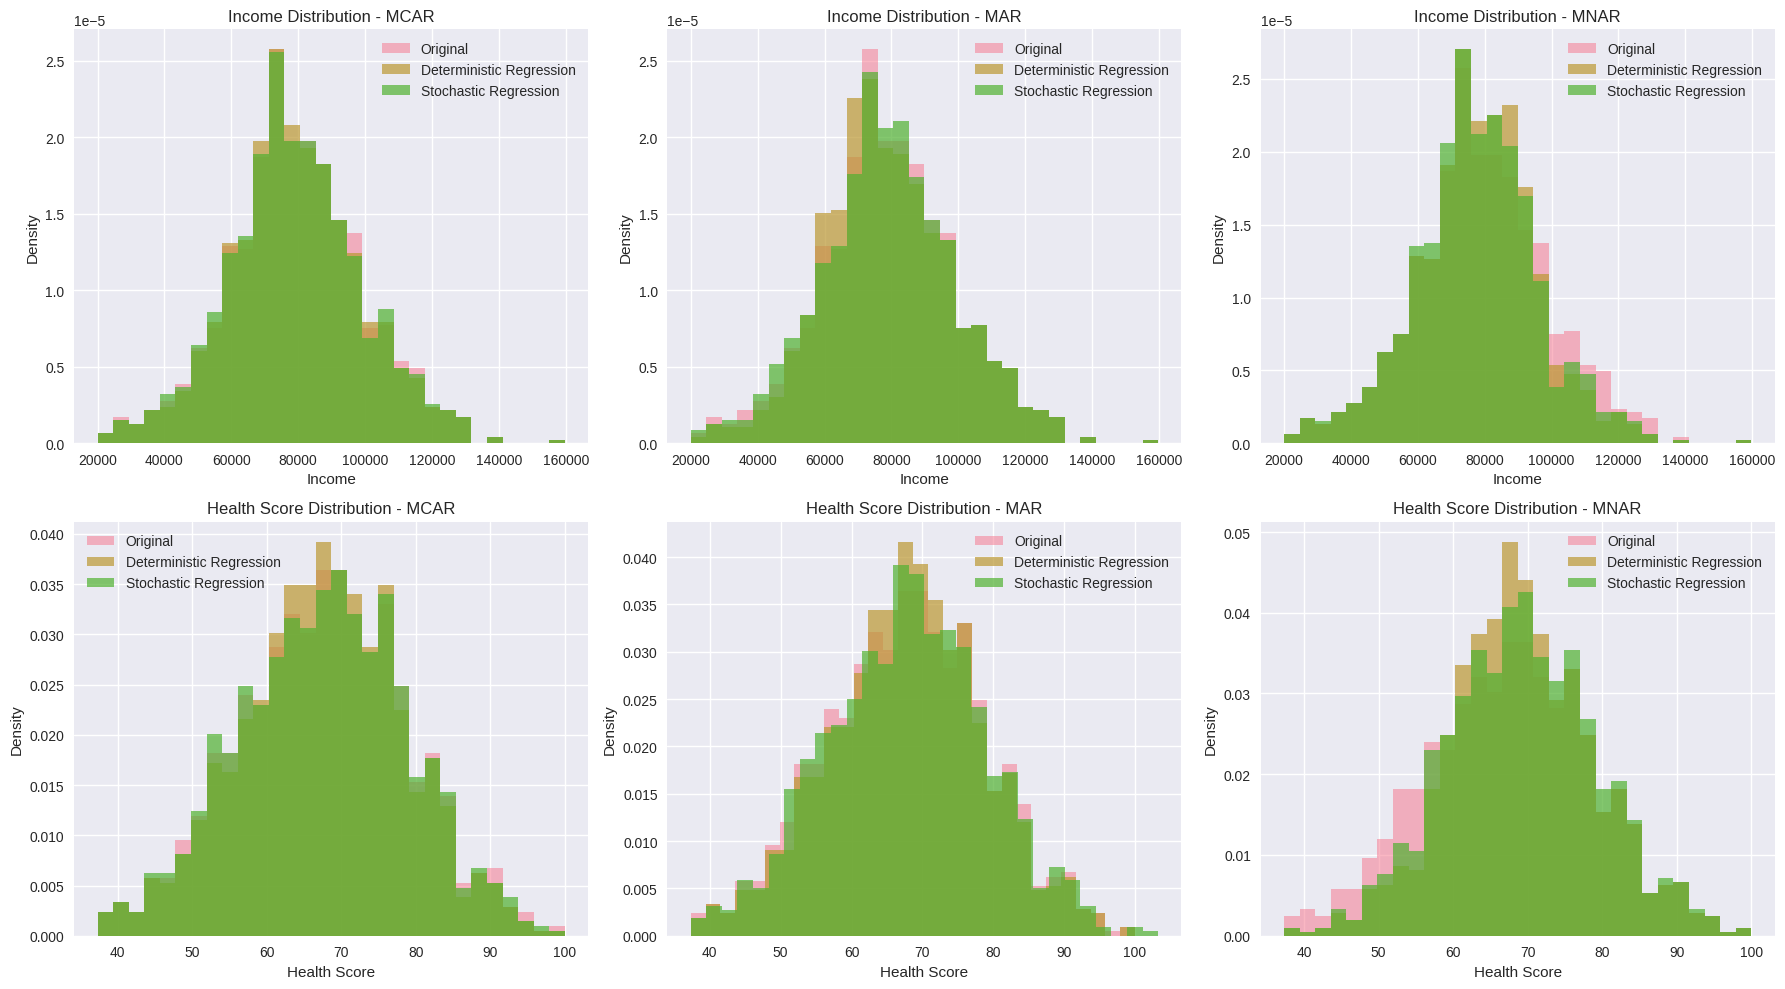

In [130]:
# Compare deterministic vs stochastic regression imputation
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

datasets_stochastic = [df_mcar_stochastic, df_mar_stochastic, df_mnar_stochastic]
datasets_regression = [df_mcar_regression, df_mar_regression, df_mnar_regression]
titles = ['MCAR', 'MAR', 'MNAR']

# Income distributions
for i, (df_stoch, df_reg, title) in enumerate(zip(datasets_stochastic, datasets_regression, titles)):
    axes[0,i].hist(df_complete['income'], bins=30, alpha=0.5, label='Original', density=True)
    axes[0,i].hist(df_reg['income'], bins=30, alpha=0.7, label='Deterministic Regression', density=True)
    axes[0,i].hist(df_stoch['income'], bins=30, alpha=0.7, label='Stochastic Regression', density=True)
    axes[0,i].set_title(f'Income Distribution - {title}')
    axes[0,i].legend()
    axes[0,i].set_xlabel('Income')
    axes[0,i].set_ylabel('Density')

# Health score distributions
for i, (df_stoch, df_reg, title) in enumerate(zip(datasets_stochastic, datasets_regression, titles)):
    axes[1,i].hist(df_complete['health_score'], bins=30, alpha=0.5, label='Original', density=True)
    axes[1,i].hist(df_reg['health_score'], bins=30, alpha=0.7, label='Deterministic Regression', density=True)
    axes[1,i].hist(df_stoch['health_score'], bins=30, alpha=0.7, label='Stochastic Regression', density=True)
    axes[1,i].set_title(f'Health Score Distribution - {title}')
    axes[1,i].legend()
    axes[1,i].set_xlabel('Health Score')
    axes[1,i].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [60]:
# Compare variance preservation between methods
print("Variance Comparison - Regression Methods")
print("="*60)

variables = ['income', 'health_score']
dataset_names = ['MCAR', 'MAR', 'MNAR']

for var in variables:
    print(f"\n{var.upper()} VARIANCE:")
    print(f"Original: {df_complete[var].var():.2f}")

    for i, name in enumerate(dataset_names):
        reg_var = datasets_regression[i][var].var()
        stoch_var = datasets_stochastic[i][var].var()
        print(f"{name} - Deterministic Regression: {reg_var:.2f}")
        print(f"{name} - Stochastic Regression: {stoch_var:.2f}")
        print()

Variance Comparison - Regression Methods

INCOME VARIANCE:
Original: 405500129.48
MCAR - Deterministic Regression: 384307362.41
MCAR - Stochastic Regression: 405940297.20

MAR - Deterministic Regression: 381635465.05
MAR - Stochastic Regression: 403279323.27

MNAR - Deterministic Regression: 334750467.12
MNAR - Stochastic Regression: 347761699.93


HEALTH_SCORE VARIANCE:
Original: 101.87
MCAR - Deterministic Regression: 93.02
MCAR - Stochastic Regression: 100.57

MAR - Deterministic Regression: 96.63
MAR - Stochastic Regression: 103.61

MNAR - Deterministic Regression: 74.40
MNAR - Stochastic Regression: 81.49



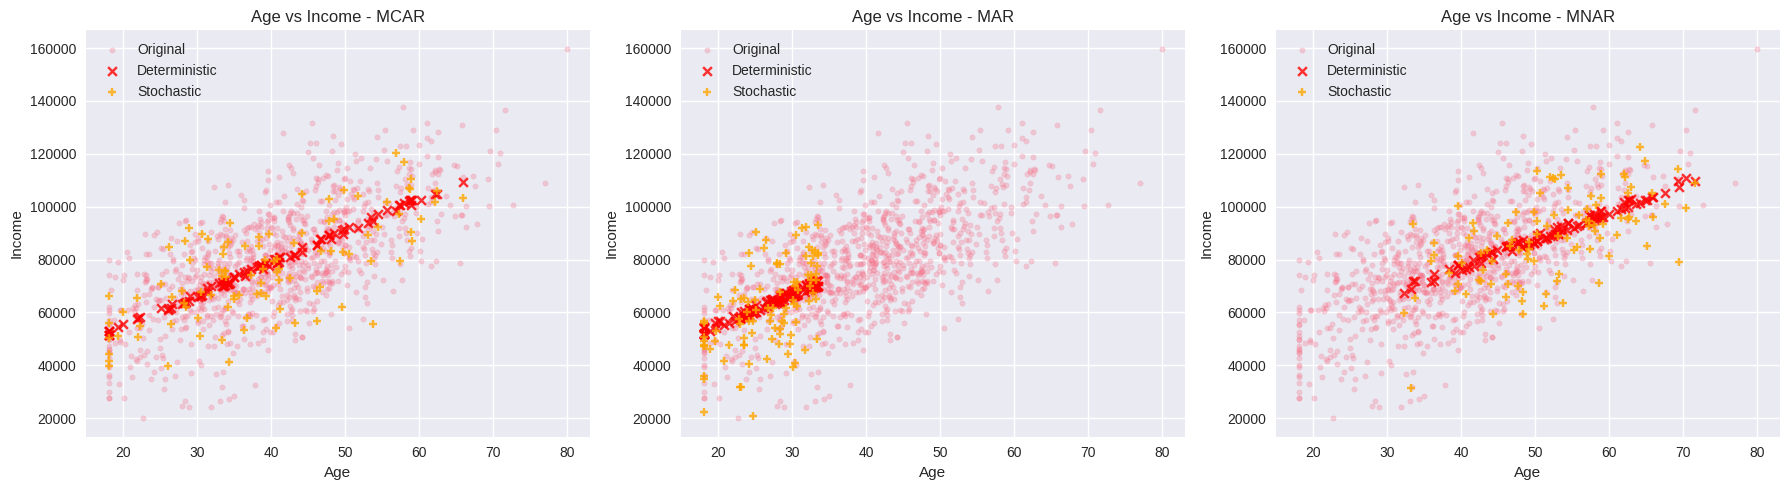

In [131]:
# Visualize the scatter plots to show the effect of adding noise
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (df_stoch, title) in enumerate(zip(datasets_stochastic, titles)):
    axes[i].scatter(df_complete['age'], df_complete['income'], alpha=0.3, label='Original', s=15)

    # Highlight imputed values from both methods
    if title == 'MCAR':
        missing_mask = df_mcar['income'].isnull()
        df_reg = df_mcar_regression
    elif title == 'MAR':
        missing_mask = df_mar['income'].isnull()
        df_reg = df_mar_regression
    else:
        missing_mask = df_mnar['income'].isnull()
        df_reg = df_mnar_regression

    if missing_mask.any():
        axes[i].scatter(df_reg.loc[missing_mask, 'age'],
                       df_reg.loc[missing_mask, 'income'],
                       alpha=0.8, label='Deterministic', s=40, marker='x', color='red')
        axes[i].scatter(df_stoch.loc[missing_mask, 'age'],
                       df_stoch.loc[missing_mask, 'income'],
                       alpha=0.8, label='Stochastic', s=40, marker='+', color='orange')

    axes[i].set_title(f'Age vs Income - {title}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Income')
    axes[i].legend()

plt.tight_layout()
plt.show()

**Observations:**
- Stochastic regression imputation preserves variance better than deterministic regression
- The added random noise helps maintain the natural variability in the data
- It still preserves the relationships between variables while adding realistic uncertainty
- The method provides a good balance between accuracy and variance preservation
- The amount of noise is calibrated based on the model's residual error
- This approach is more realistic than deterministic regression for most real-world scenarios

### 4.6 K-Nearest Neighbors (KNN) Imputation

KNN imputation replaces missing values using the mean/mode of the k nearest neighbors. This method can capture non-linear relationships and works well when similar observations have similar values for the missing variable.

In [132]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

def knn_imputation(df, n_neighbors=5, random_state=42):
    """
    Perform KNN imputation on a dataframe.

    Parameters:
    df: DataFrame with missing values
    n_neighbors: Number of neighbors to use for imputation
    random_state: Random seed for reproducibility

    Returns:
    DataFrame with imputed values
    """
    df_imputed = df.copy()
    np.random.seed(random_state)

    # Separate numerical and categorical columns
    numerical_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object']).columns.tolist()

    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")

    # Encode categorical variables for KNN
    df_encoded = df_imputed.copy()
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

    # Standardize numerical features for better distance calculation
    scaler = StandardScaler()

    # Only standardize if we have numerical columns
    if numerical_cols:
        # Fit scaler on non-missing values
        non_missing_mask = df_encoded[numerical_cols].notna().all(axis=1)
        if non_missing_mask.sum() > 0:
            scaler.fit(df_encoded.loc[non_missing_mask, numerical_cols])

            # Transform all numerical data
            df_encoded[numerical_cols] = scaler.transform(df_encoded[numerical_cols])

    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)

    print(f"\nApplying KNN imputation with {n_neighbors} neighbors...")
    df_imputed_values = imputer.fit_transform(df_encoded)

    # Create new dataframe with imputed values
    df_knn_imputed = pd.DataFrame(df_imputed_values, columns=df_encoded.columns, index=df_encoded.index)

    # Inverse transform numerical columns
    if numerical_cols:
        df_knn_imputed[numerical_cols] = scaler.inverse_transform(df_knn_imputed[numerical_cols])

    # Inverse transform categorical columns
    for col in categorical_cols:
        # Round to nearest integer for categorical variables
        rounded_values = np.round(df_knn_imputed[col]).astype(int)
        # Ensure values are within valid range
        rounded_values = np.clip(rounded_values, 0, len(label_encoders[col].classes_) - 1)
        df_knn_imputed[col] = label_encoders[col].inverse_transform(rounded_values)

    # Count imputed values
    for col in df.columns:
        if df[col].isnull().any():
            n_imputed = df[col].isnull().sum()
            print(f"Imputed {n_imputed} values for {col}")

    return df_knn_imputed

In [133]:
# Apply KNN imputation to all three datasets
print("=== K-Nearest Neighbors Imputation ===")

df_mcar_knn = knn_imputation(df_mcar, n_neighbors=5, random_state=42)
print("\nMCAR dataset after KNN imputation:")
print(df_mcar_knn.isnull().sum())

print("\n" + "="*70)
df_mar_knn = knn_imputation(df_mar, n_neighbors=5, random_state=42)
print("\nMAR dataset after KNN imputation:")
print(df_mar_knn.isnull().sum())

print("\n" + "="*70)
df_mnar_knn = knn_imputation(df_mnar, n_neighbors=5, random_state=42)
print("\nMNAR dataset after KNN imputation:")
print(df_mnar_knn.isnull().sum())

=== K-Nearest Neighbors Imputation ===
Numerical columns: ['age', 'income', 'education_years', 'health_score']
Categorical columns: ['gender', 'city']

Applying KNN imputation with 5 neighbors...
Imputed 100 values for income
Imputed 100 values for health_score

MCAR dataset after KNN imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Numerical columns: ['age', 'income', 'education_years', 'health_score']
Categorical columns: ['gender', 'city']

Applying KNN imputation with 5 neighbors...
Imputed 99 values for income
Imputed 99 values for health_score

MAR dataset after KNN imputation:
age                0
income             0
education_years    0
health_score       0
gender             0
city               0
dtype: int64

Numerical columns: ['age', 'income', 'education_years', 'health_score']
Categorical columns: ['gender', 'city']

Applying KNN imputation with 5 neighbors...
Imputed 1

In [134]:
# Test different values of k
k_values = [3, 5, 10, 15]
print("Testing different k values for KNN imputation (using MCAR dataset)")
print("="*60)

knn_results = {}
for k in k_values:
    print(f"\nTesting k={k}:")
    df_test = knn_imputation(df_mcar, n_neighbors=k, random_state=42)
    knn_results[k] = df_test

    # Calculate variance for income
    income_var = df_test['income'].var()
    health_var = df_test['health_score'].var()
    print(f"Income variance: {income_var:.2f}")
    print(f"Health score variance: {health_var:.2f}")

print(f"\nOriginal variances:")
print(f"Income variance: {df_complete['income'].var():.2f}")
print(f"Health score variance: {df_complete['health_score'].var():.2f}")

Testing different k values for KNN imputation (using MCAR dataset)

Testing k=3:
Numerical columns: ['age', 'income', 'education_years', 'health_score']
Categorical columns: ['gender', 'city']

Applying KNN imputation with 3 neighbors...
Imputed 100 values for income
Imputed 100 values for health_score
Income variance: 394448884.65
Health score variance: 120.58

Testing k=5:
Numerical columns: ['age', 'income', 'education_years', 'health_score']
Categorical columns: ['gender', 'city']

Applying KNN imputation with 5 neighbors...
Imputed 100 values for income
Imputed 100 values for health_score
Income variance: 390439081.74
Health score variance: 119.46

Testing k=10:
Numerical columns: ['age', 'income', 'education_years', 'health_score']
Categorical columns: ['gender', 'city']

Applying KNN imputation with 10 neighbors...
Imputed 100 values for income
Imputed 100 values for health_score
Income variance: 389496468.41
Health score variance: 118.30

Testing k=15:
Numerical columns: ['age'

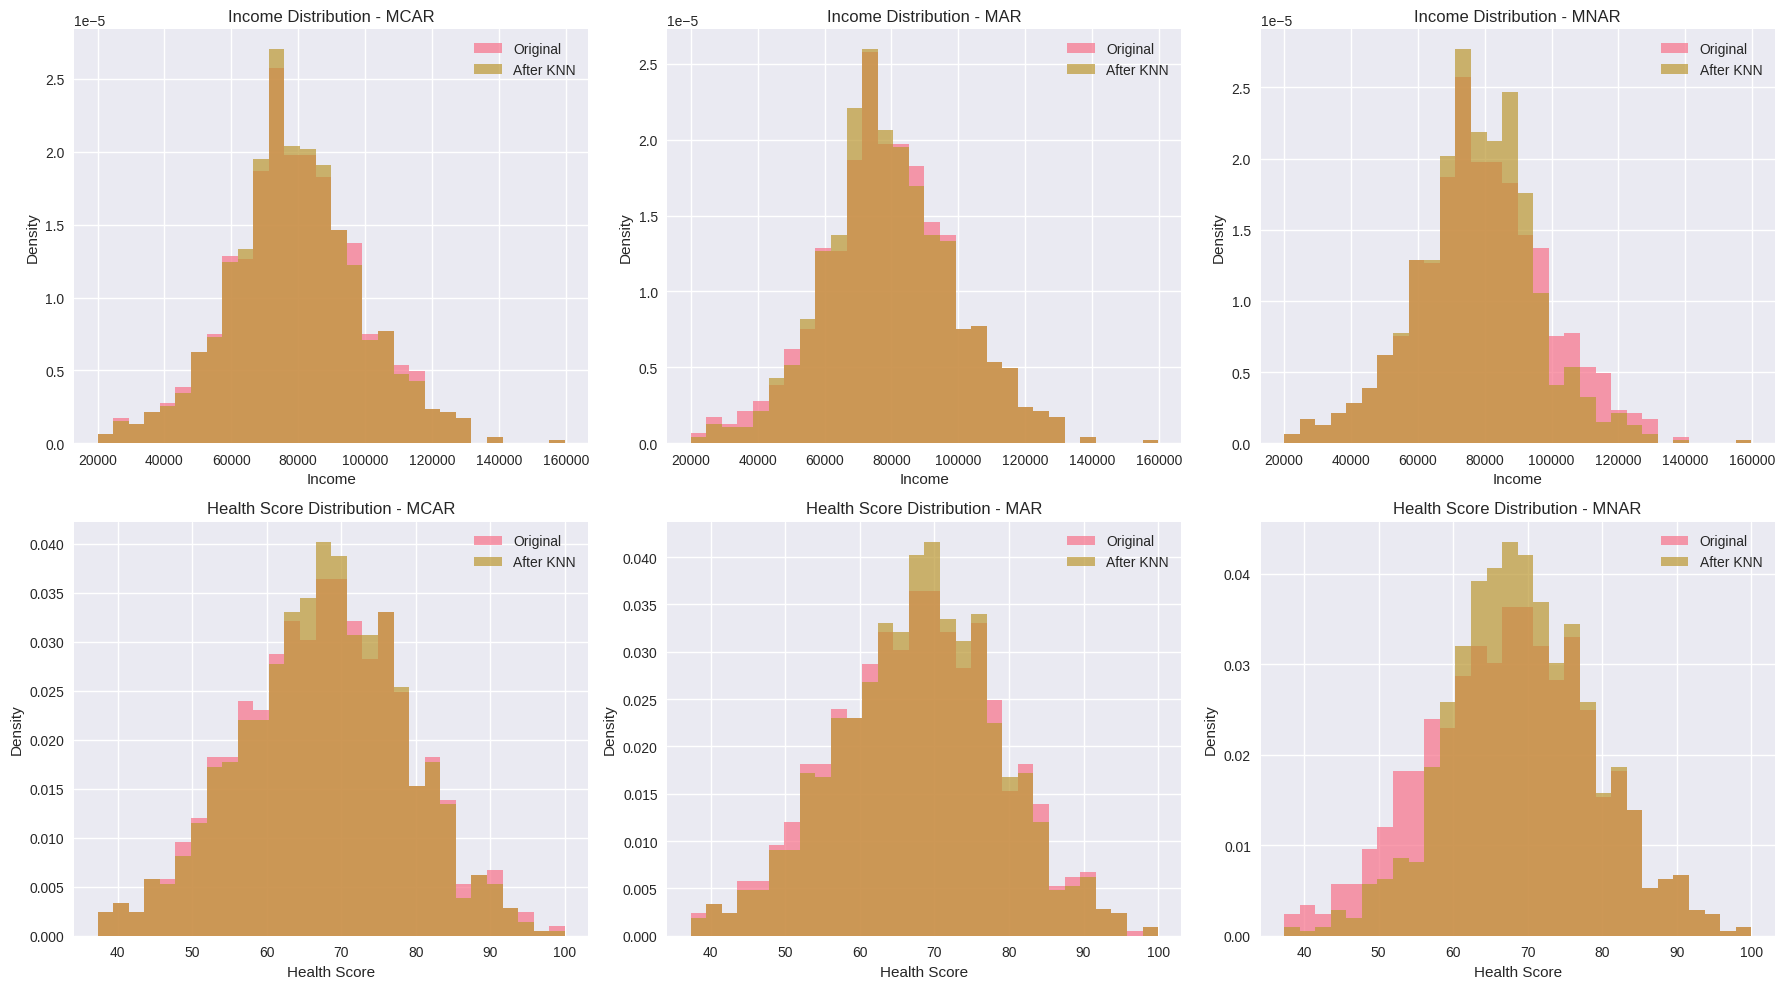

In [135]:
# Visualize KNN imputation results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

datasets_knn = [df_mcar_knn, df_mar_knn, df_mnar_knn]
titles = ['MCAR', 'MAR', 'MNAR']

# Income distributions
for i, (df_imputed, title) in enumerate(zip(datasets_knn, titles)):
    axes[0,i].hist(df_complete['income'], bins=30, alpha=0.7, label='Original', density=True)
    axes[0,i].hist(df_imputed['income'], bins=30, alpha=0.7, label='After KNN', density=True)
    axes[0,i].set_title(f'Income Distribution - {title}')
    axes[0,i].legend()
    axes[0,i].set_xlabel('Income')
    axes[0,i].set_ylabel('Density')

# Health score distributions
for i, (df_imputed, title) in enumerate(zip(datasets_knn, titles)):
    axes[1,i].hist(df_complete['health_score'], bins=30, alpha=0.7, label='Original', density=True)
    axes[1,i].hist(df_imputed['health_score'], bins=30, alpha=0.7, label='After KNN', density=True)
    axes[1,i].set_title(f'Health Score Distribution - {title}')
    axes[1,i].legend()
    axes[1,i].set_xlabel('Health Score')
    axes[1,i].set_ylabel('Density')

plt.tight_layout()
plt.show()

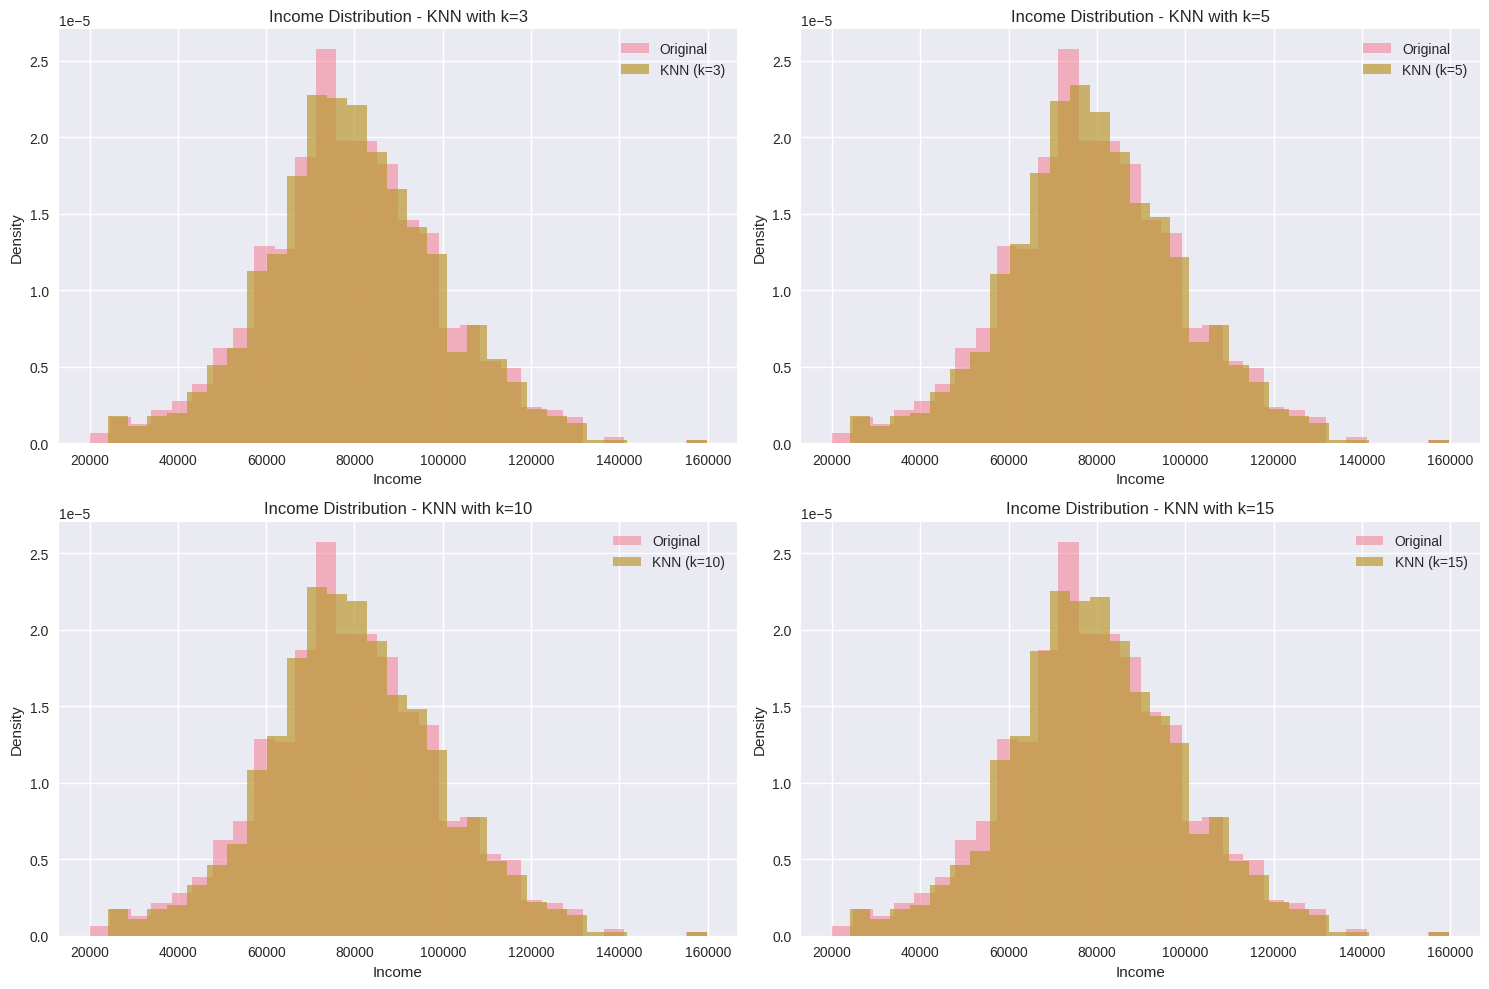

In [34]:
# Compare different k values visually
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, k in enumerate(k_values):
    df_k = knn_results[k]

    axes[i].hist(df_complete['income'], bins=30, alpha=0.5, label='Original', density=True)
    axes[i].hist(df_k['income'], bins=30, alpha=0.7, label=f'KNN (k={k})', density=True)
    axes[i].set_title(f'Income Distribution - KNN with k={k}')
    axes[i].legend()
    axes[i].set_xlabel('Income')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

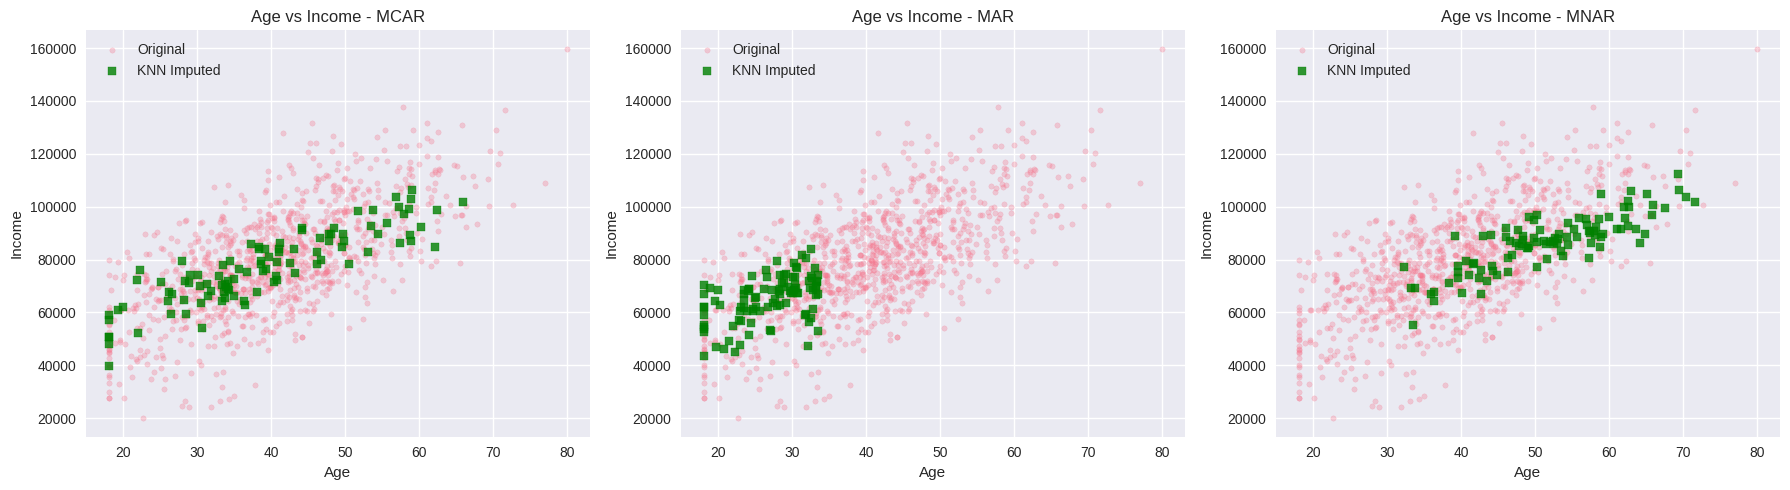

In [136]:
# Analyze relationship preservation with KNN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (df_imputed, title) in enumerate(zip(datasets_knn, titles)):
    axes[i].scatter(df_complete['age'], df_complete['income'], alpha=0.3, label='Original', s=15)

    # Highlight imputed values
    if title == 'MCAR':
        missing_mask = df_mcar['income'].isnull()
    elif title == 'MAR':
        missing_mask = df_mar['income'].isnull()
    else:
        missing_mask = df_mnar['income'].isnull()

    if missing_mask.any():
        axes[i].scatter(df_imputed.loc[missing_mask, 'age'],
                       df_imputed.loc[missing_mask, 'income'],
                       alpha=0.8, label='KNN Imputed', s=40, marker='s', color='green')

    axes[i].set_title(f'Age vs Income - {title}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Income')
    axes[i].legend()

plt.tight_layout()
plt.show()

**Observations:**
- KNN imputation can capture non-linear relationships between variables
- The choice of k affects the smoothness of imputations (lower k = more variable, higher k = smoother)
- It works well when similar observations have similar values for missing variables
- The method preserves local patterns in the data
- Computational complexity increases with dataset size
- Performance depends on the distance metric and feature scaling
- Generally provides good balance between accuracy and variance preservation

## 5. Comparison and Evaluation

Now let's compare all the imputation methods across different metrics and missing data patterns.

In [45]:
# Create a comprehensive comparison function
def evaluate_imputation_performance(original_df, imputed_datasets, method_names, missing_patterns):
    """
    Evaluate imputation performance across different metrics.

    Parameters:
    original_df: The complete original dataset
    imputed_datasets: Dictionary of imputed datasets {pattern: {method: df}}
    method_names: List of method names
    missing_patterns: List of missing pattern names

    Returns:
    DataFrame with evaluation results
    """
    results = []

    for pattern in missing_patterns:
        for method in method_names:
            df_imputed = imputed_datasets[pattern][method]

            # Calculate metrics for numerical variables
            for var in ['income', 'health_score']:
                # Mean Squared Error (for imputed values only)
                if pattern == 'MCAR':
                    missing_mask = df_mcar[var].isnull()
                elif pattern == 'MAR':
                    missing_mask = df_mar[var].isnull()
                else:
                    missing_mask = df_mnar[var].isnull()

                if missing_mask.any():
                    true_values = original_df.loc[missing_mask, var]
                    imputed_values = df_imputed.loc[missing_mask, var]

                    mse = mean_squared_error(true_values, imputed_values)
                    mae = mean_absolute_error(true_values, imputed_values)

                    # Variance preservation
                    original_var = original_df[var].var()
                    imputed_var = df_imputed[var].var()
                    var_ratio = imputed_var / original_var

                    # Mean preservation
                    original_mean = original_df[var].mean()
                    imputed_mean = df_imputed[var].mean()
                    mean_diff = abs(imputed_mean - original_mean)

                    results.append({
                        'Pattern': pattern,
                        'Method': method,
                        'Variable': var,
                        'MSE': mse,
                        'MAE': mae,
                        'Variance_Ratio': var_ratio,
                        'Mean_Difference': mean_diff
                    })

    return pd.DataFrame(results)

In [46]:
# Organize all imputed datasets
imputed_datasets = {
    'MCAR': {
        'Mean': df_mcar_mean,
        'Median': df_mcar_median,
        'Random': df_mcar_random,
        'Hot Deck': df_mcar_hotdeck,
        'Regression': df_mcar_regression,
        'Stochastic': df_mcar_stochastic,
        'KNN': df_mcar_knn
    },
    'MAR': {
        'Mean': df_mar_mean,
        'Median': df_mar_median,
        'Random': df_mar_random,
        'Hot Deck': df_mar_hotdeck,
        'Regression': df_mar_regression,
        'Stochastic': df_mar_stochastic,
        'KNN': df_mar_knn
    },
    'MNAR': {
        'Mean': df_mnar_mean,
        'Median': df_mnar_median,
        'Random': df_mnar_random,
        'Hot Deck': df_mnar_hotdeck,
        'Regression': df_mnar_regression,
        'Stochastic': df_mnar_stochastic,
        'KNN': df_mnar_knn
    }
}

method_names = ['Mean', 'Median', 'Random', 'Hot Deck', 'Regression', 'Stochastic', 'KNN']
missing_patterns = ['MCAR', 'MAR', 'MNAR']

# Evaluate performance
evaluation_results = evaluate_imputation_performance(
    df_complete, imputed_datasets, method_names, missing_patterns
)

print("Evaluation Results:")
print(evaluation_results.head(10))

Evaluation Results:
  Pattern      Method      Variable           MSE           MAE  \
0    MCAR        Mean        income  4.297414e+08  15438.992539   
1    MCAR        Mean  health_score  1.030124e+02      8.610866   
2    MCAR      Median        income  4.238070e+08  15456.901423   
3    MCAR      Median  health_score  1.054010e+02      8.598206   
4    MCAR      Random        income  1.071234e+09  25017.929679   
5    MCAR      Random  health_score  2.399089e+02     12.725530   
6    MCAR    Hot Deck        income  4.437735e+08  16783.280510   
7    MCAR    Hot Deck  health_score  1.830254e+02     10.804607   
8    MCAR  Regression        income  2.282733e+08  11458.195683   
9    MCAR  Regression  health_score  9.697950e+01      8.194228   

   Variance_Ratio  Mean_Difference  
0        0.894180       326.974248  
1        0.898824         0.065067  
2        0.894443       218.101170  
3        0.899755         0.167689  
4        1.012538       734.462181  
5        1.026954   

In [47]:
# Create summary tables for each metric
def create_summary_table(results_df, metric, variable):
    """
    Create a summary table for a specific metric and variable.
    """
    filtered_df = results_df[results_df['Variable'] == variable]
    pivot_table = filtered_df.pivot(index='Method', columns='Pattern', values=metric)
    return pivot_table

# MSE comparison for income
print("Mean Squared Error (MSE) - Income")
print("=" * 40)
mse_income = create_summary_table(evaluation_results, 'MSE', 'income')
print(mse_income.round(2))

print("\nMean Squared Error (MSE) - Health Score")
print("=" * 40)
mse_health = create_summary_table(evaluation_results, 'MSE', 'health_score')
print(mse_health.round(2))

Mean Squared Error (MSE) - Income
Pattern              MAR          MCAR          MNAR
Method                                              
Hot Deck    4.254675e+08  4.437735e+08  6.942229e+08
KNN         2.959977e+08  2.736524e+08  5.710177e+08
Mean        5.684719e+08  4.297414e+08  1.054593e+09
Median      5.462729e+08  4.238070e+08  1.067345e+09
Random      9.481523e+08  1.071234e+09  1.445313e+09
Regression  2.229586e+08  2.282733e+08  4.390957e+08
Stochastic  3.367907e+08  4.374436e+08  6.567198e+08

Mean Squared Error (MSE) - Health Score
Pattern        MAR    MCAR    MNAR
Method                            
Hot Deck    124.55  183.03  300.31
KNN          90.63  104.68  277.50
Mean         68.73  103.01  320.61
Median       70.25  105.40  341.00
Random      169.58  239.91  379.46
Regression   67.11   96.98  246.96
Stochastic  132.94  164.48  312.89


In [48]:
# Variance ratio comparison
print("Variance Preservation Ratio - Income")
print("=" * 40)
var_ratio_income = create_summary_table(evaluation_results, 'Variance_Ratio', 'income')
print(var_ratio_income.round(3))

print("\nVariance Preservation Ratio - Health Score")
print("=" * 40)
var_ratio_health = create_summary_table(evaluation_results, 'Variance_Ratio', 'health_score')
print(var_ratio_health.round(3))

print("\nNote: Ratio close to 1.0 indicates better variance preservation")

Variance Preservation Ratio - Income
Pattern       MAR   MCAR   MNAR
Method                         
Hot Deck    0.989  0.998  0.864
KNN         0.935  0.939  0.817
Mean        0.869  0.894  0.763
Median      0.869  0.894  0.763
Random      0.970  1.013  0.867
Regression  0.941  0.948  0.826
Stochastic  0.995  1.001  0.858

Variance Preservation Ratio - Health Score
Pattern       MAR   MCAR   MNAR
Method                         
Hot Deck    1.020  0.997  0.804
KNN         0.962  0.924  0.742
Mean        0.933  0.899  0.714
Median      0.934  0.900  0.714
Random      1.043  1.027  0.792
Regression  0.949  0.913  0.730
Stochastic  1.017  0.987  0.800

Note: Ratio close to 1.0 indicates better variance preservation


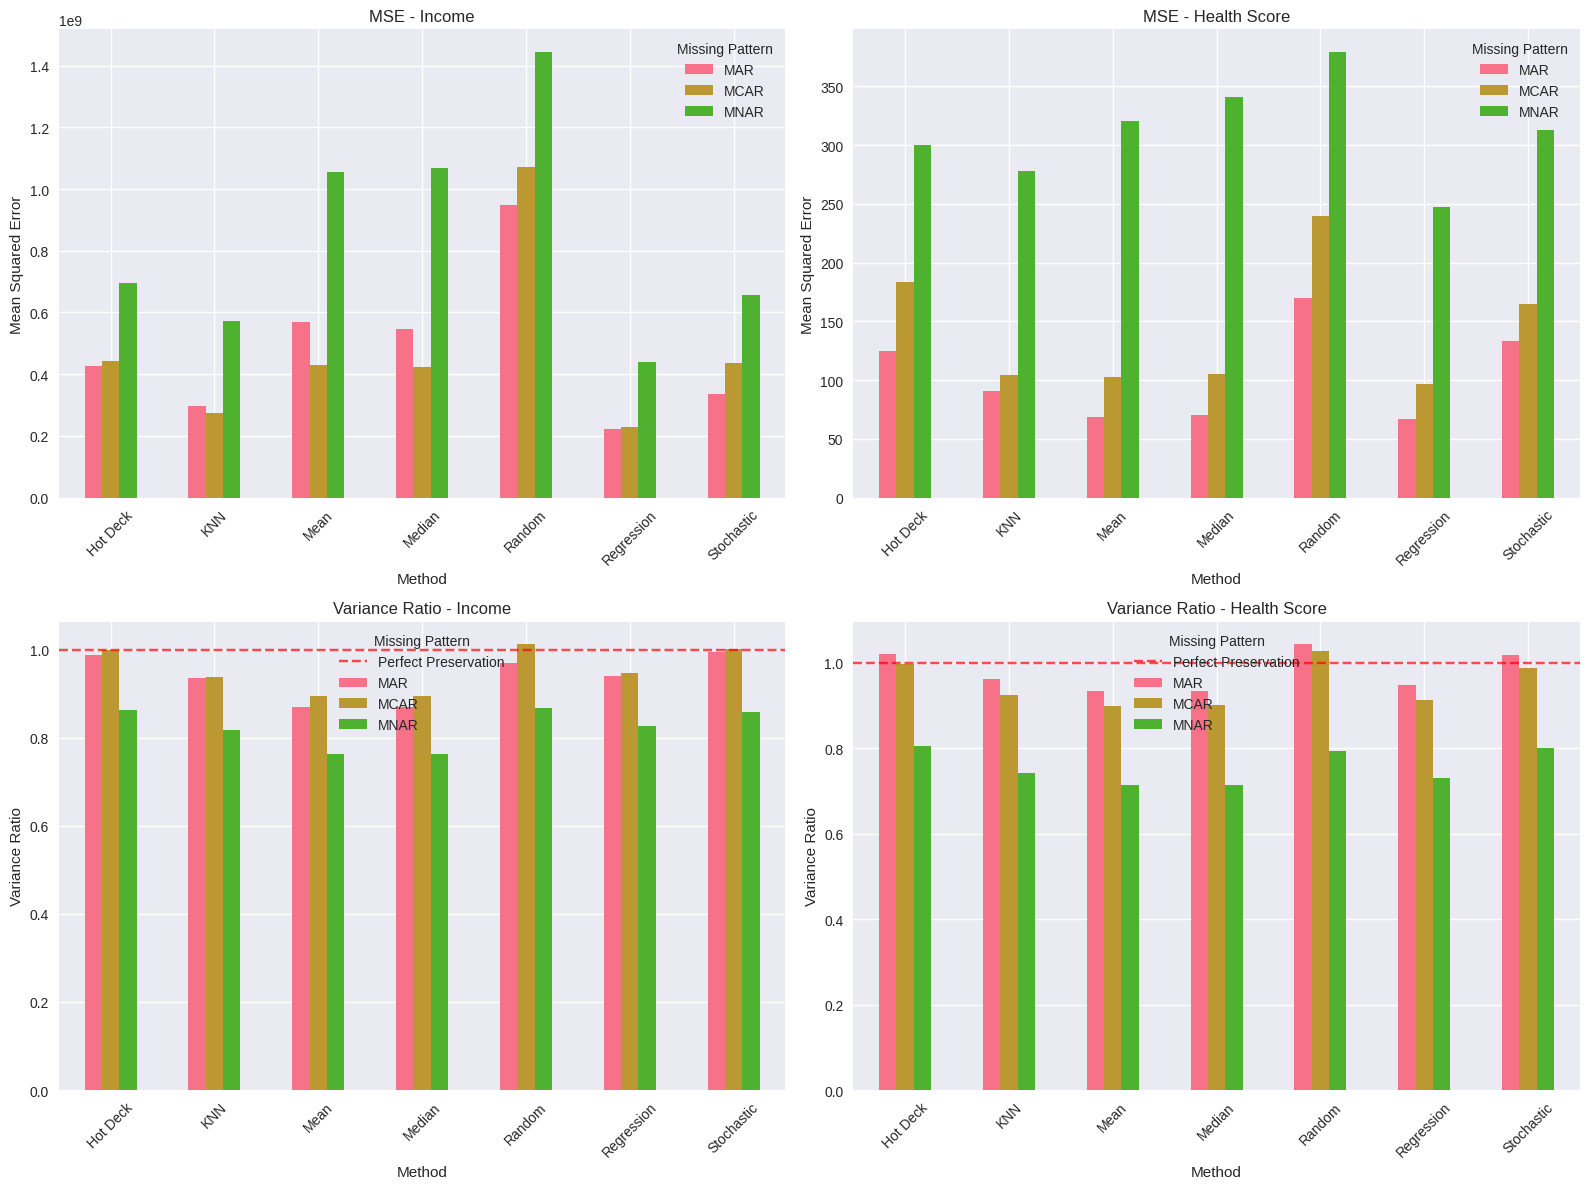

In [49]:
# Create comprehensive visualization of results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MSE comparison
mse_income.plot(kind='bar', ax=axes[0,0], title='MSE - Income')
axes[0,0].set_ylabel('Mean Squared Error')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend(title='Missing Pattern')

mse_health.plot(kind='bar', ax=axes[0,1], title='MSE - Health Score')
axes[0,1].set_ylabel('Mean Squared Error')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(title='Missing Pattern')

# Variance ratio comparison
var_ratio_income.plot(kind='bar', ax=axes[1,0], title='Variance Ratio - Income')
axes[1,0].set_ylabel('Variance Ratio')
axes[1,0].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Preservation')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Missing Pattern')

var_ratio_health.plot(kind='bar', ax=axes[1,1], title='Variance Ratio - Health Score')
axes[1,1].set_ylabel('Variance Ratio')
axes[1,1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Preservation')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(title='Missing Pattern')

plt.tight_layout()
plt.show()

In [137]:
# Create a ranking system
def rank_methods(results_df):
    """
    Rank methods based on multiple criteria.
    Lower MSE is better, variance ratio closer to 1 is better.
    """
    rankings = []

    for pattern in missing_patterns:
        for variable in ['income', 'health_score']:
            subset = results_df[
                (results_df['Pattern'] == pattern) &
                (results_df['Variable'] == variable)
            ].copy()

            # Rank by MSE (lower is better)
            subset['MSE_Rank'] = subset['MSE'].rank()

            # Rank by variance ratio (closer to 1 is better)
            subset['Var_Rank'] = abs(subset['Variance_Ratio'] - 1).rank()

            # Combined rank (lower is better)
            subset['Combined_Rank'] = (subset['MSE_Rank'] + subset['Var_Rank']) / 2

            rankings.append(subset)

    return pd.concat(rankings, ignore_index=True)

ranked_results = rank_methods(evaluation_results)

# Show top methods for each pattern and variable
print("Method Rankings (Lower Combined Rank = Better Performance)")
print("=" * 60)

for pattern in missing_patterns:
    for variable in ['income', 'health_score']:
        subset = ranked_results[
            (ranked_results['Pattern'] == pattern) &
            (ranked_results['Variable'] == variable)
        ].sort_values('Combined_Rank')

        print(f"\n{pattern} - {variable.title()}:")
        for i, (_, row) in enumerate(subset.head(3).iterrows()):
            print(f"  {i+1}. {row['Method']} (Combined Rank: {row['Combined_Rank']:.2f})")

Method Rankings (Lower Combined Rank = Better Performance)

MCAR - Income:
  1. Regression (Combined Rank: 2.50)
  2. Stochastic (Combined Rank: 3.00)
  3. KNN (Combined Rank: 3.50)

MCAR - Health_Score:
  1. Regression (Combined Rank: 3.00)
  2. Hot Deck (Combined Rank: 3.50)
  3. Stochastic (Combined Rank: 3.50)

MAR - Income:
  1. Stochastic (Combined Rank: 2.00)
  2. Regression (Combined Rank: 2.50)
  3. Hot Deck (Combined Rank: 3.00)

MAR - Health_Score:
  1. Regression (Combined Rank: 3.00)
  2. Hot Deck (Combined Rank: 3.50)
  3. Stochastic (Combined Rank: 3.50)

MNAR - Income:
  1. Regression (Combined Rank: 2.50)
  2. Hot Deck (Combined Rank: 3.00)
  3. Stochastic (Combined Rank: 3.00)

MNAR - Health_Score:
  1. Hot Deck (Combined Rank: 2.00)
  2. KNN (Combined Rank: 3.00)
  3. Stochastic (Combined Rank: 3.00)


## 6. Summary and Recommendations

Based on our comprehensive analysis of different imputation methods across MCAR, MAR, and MNAR missing data patterns, here are the key findings:

### Method Characteristics:

1. **Mean/Median/Mode Imputation**:
   - Simple and fast
   - Reduces variance significantly
   - Best for quick analysis when accuracy is not critical
   - Poor performance with MAR and MNAR data

2. **Random Imputation**:
   - Preserves marginal distributions well
   - Maintains original variance
   - Ignores relationships between variables
   - Good baseline method for MCAR data

3. **Hot Deck Imputation**:
   - Uses similarity-based matching
   - Preserves relationships between variables
   - Performance depends on quality of donor records
   - Good for mixed-type data

4. **Linear Regression Imputation**:
   - Models relationships explicitly
   - Good for data with strong linear relationships
   - Underestimates variance (deterministic)
   - Can produce unrealistic values outside observed range

5. **Stochastic Regression Imputation**:
   - Combines regression modeling with variance preservation
   - Adds appropriate amount of uncertainty
   - Better balance between accuracy and realism
   - Good general-purpose method

6. **K-Nearest Neighbors (KNN)**:
   - Can capture non-linear relationships
   - Flexible and robust
   - Computationally intensive for large datasets
   - Generally good performance across different scenarios

### Recommendations by Missing Data Mechanism:

- **MCAR**: KNN, Stochastic Regression, or Random Imputation
- **MAR**: KNN, Stochastic Regression, or Hot Deck
- **MNAR**: More complex methods needed (beyond scope of basic imputation)

### General Guidelines:

1. Always understand your missing data mechanism first
2. Consider the trade-off between computational cost and accuracy
3. Validate imputation quality using cross-validation when possible
4. Consider multiple imputation for important analyses
5. Document your imputation strategy for reproducibility

## 7. Conclusion

This notebook has demonstrated six different imputation methods for handling missing data:

1. **Mean/Median/Mode Imputation** - Simple but reduces variance
2. **Random Imputation** - Preserves distributions but ignores relationships
3. **Hot Deck Imputation** - Uses similar records for realistic values
4. **Linear Regression Imputation** - Models relationships but underestimates variance
5. **Stochastic Regression Imputation** - Adds uncertainty to regression predictions
6. **K-Nearest Neighbors Imputation** - Flexible method that can capture complex patterns

Each method has its strengths and weaknesses, and the choice depends on:
- The missing data mechanism (MCAR, MAR, MNAR)
- The relationships between variables
- The importance of preserving variance vs. accuracy
- Computational constraints
- The intended use of the imputed data

### Key Takeaways:

- **No single method is universally best** - the optimal choice depends on your specific context
- **Understanding your missing data mechanism is crucial** for selecting appropriate methods
- **Evaluate imputation quality** using appropriate metrics before proceeding with analysis
- **Document your approach** for reproducibility and transparency
